Arieldhipta Tarliman - 2702234636

Sebagai data scientist, Anda mendapat tantangan untuk menyelesaikan masalah data image yang memiliki noise. Anda perlu membangun model deep learning yang mampu membersihkan data image yang mengandung noise menjadi data yang bersih tanpa noise. Namun sayangnya, Anda tidak memiliki data yang mengandung noise dengan cukup, sehingga Anda perlu membuat image data dengan memberikan noise nilai acak yang diambil dari distribusi normal (Gaussian), menggunakan rata-rata 0.0 dan standard deviasi 0.1.

Data image yang Anda gunakan adalah data pada link berikut:https://drive.google.com/drive/folders/1-Tdpj25TUPpn_FBfNVcEoTtjQstTKOZl?usp=sharing, dimana jika Anda memiliki NIM genap, Anda akan menggunakan data A_23, dan bila Anda memiliki NIM ganjil akan menggunakan data B_23.


File & Video : https://binusianorg-my.sharepoint.com/personal/arieldhipta_tarliman_binus_ac_id/_layouts/15/guestaccess.aspx?share=EjVVBWskzrxOtG4HPufz4WoB7IG1jXh0KKIEc7cDfrgRJw&e=HfjLN2

# Import Library

In [ ]:
import os
import cv2
from tqdm import tqdm
import random
import hashlib
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from collections import defaultdict
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Dropout, LeakyReLU
from keras.optimizers import Adam
from keras.models import Model
from keras.callbacks import EarlyStopping 

import warnings
import absl.logging
warnings.filterwarnings("ignore", category=UserWarning, module="absl")
tf.get_logger().setLevel('ERROR')  # Suppress warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow logging
absl.logging.set_verbosity(absl.logging.ERROR)

SEED = 42
random.seed(SEED)           # Python's built-in random module
np.random.seed(SEED)        # NumPy
tf.random.set_seed(SEED)    # TensorFlow
os.environ['PYTHONHASHSEED'] = str(SEED) 

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

In [2]:
# Limit GPU memory growth instead of allocating all at once
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth set.")
    except RuntimeError as e:
        print(e)

GPU memory growth set.


In [3]:
dataset_path = './A_23'

In [4]:
image_files = os.listdir(dataset_path)
image_files = [f for f in image_files if f.endswith(('.jpg', '.jpeg', '.png'))]
total_files = [f for f in image_files]

# EDA

In [5]:
print(f"Number of images found: {len(image_files)}")

Number of images found: 1074


In [6]:
# Count occurrences
kirmizi_count = sum(1 for f in image_files if 'kirmizi' in f.lower())
siirt_count = sum(1 for f in image_files if 'siirt' in f.lower())

print(f"Number of 'kirmizi' images: {kirmizi_count}")
print(f"Number of 'siirt' images: {siirt_count}")

Number of 'kirmizi' images: 616
Number of 'siirt' images: 458


## Check Samples

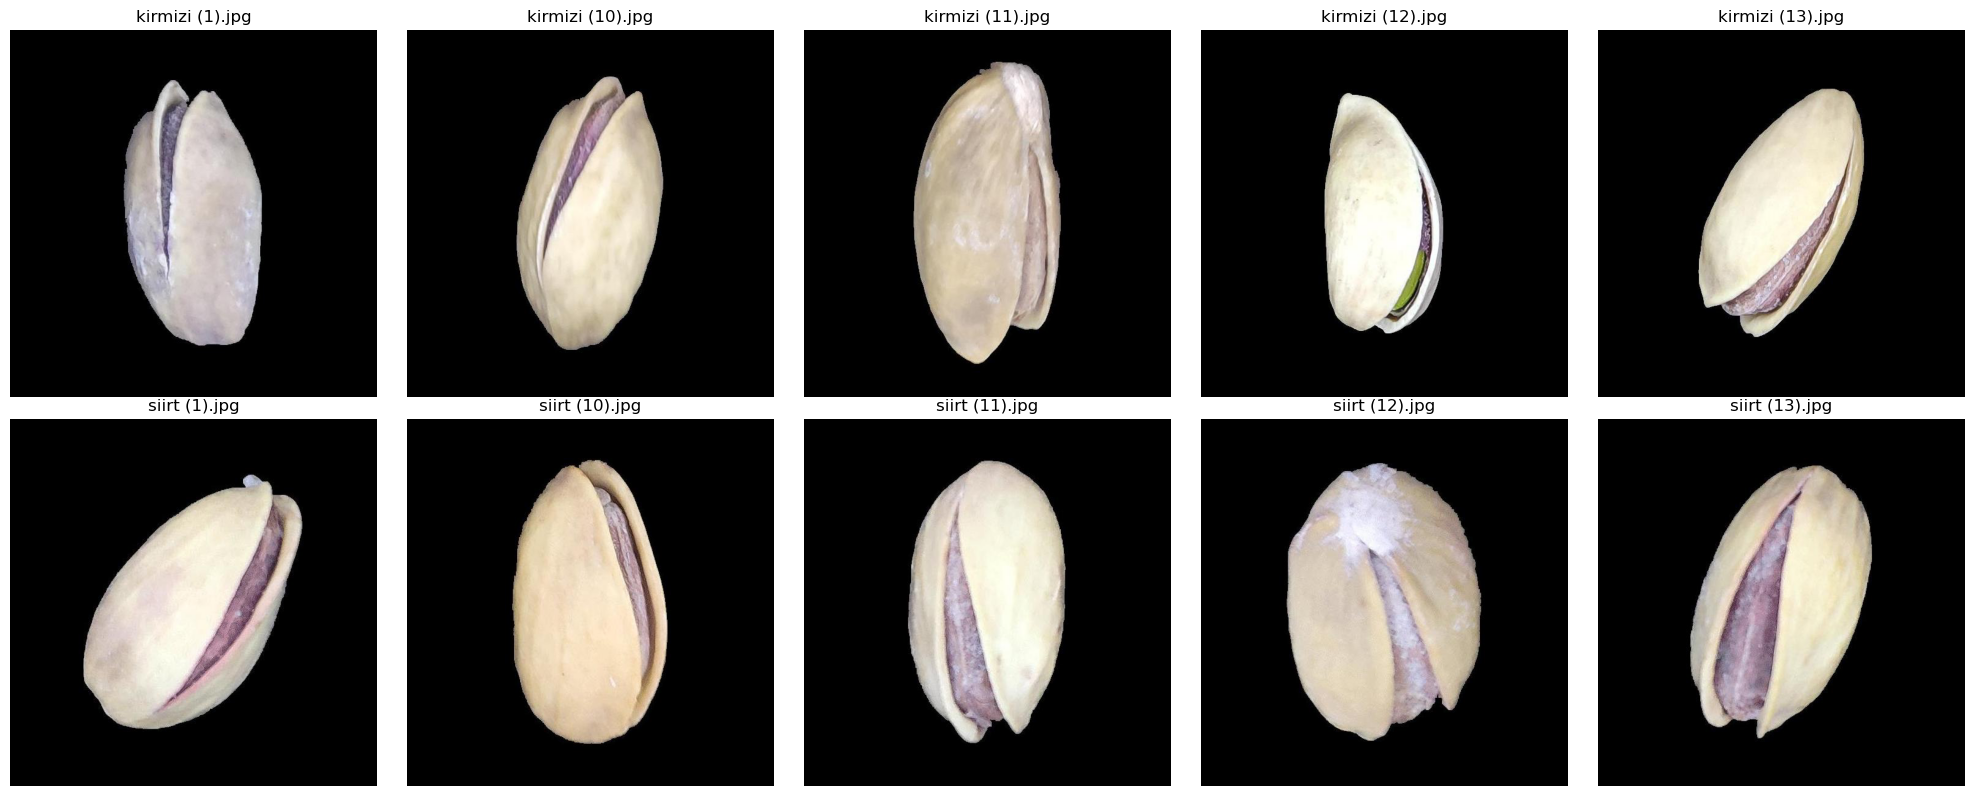

In [7]:
# Filter kirmizi and siirt images
kirmizi_images = [f for f in image_files if 'kirmizi' in f.lower()][:5]
siirt_images = [f for f in image_files if 'siirt' in f.lower()][:5]

# Combine for display
selected_images = kirmizi_images + siirt_images

# Display images
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
axs = axs.flatten()

for ax, image_file in zip(axs, selected_images):
    img_path = os.path.join(dataset_path, image_file)
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(image_file)

plt.tight_layout()
plt.show()

## Check Corrupted Images

In [8]:
def check_corrupted_files(directory):
    corrupted = []
    image_files = [f for f in os.listdir(directory) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    for filename in image_files:
        img_path = os.path.join(directory, filename)
        try:
            with Image.open(img_path) as img:
                img.verify()  # Verifies image integrity without loading pixels
        except:
            corrupted.append(img_path)
    return corrupted

# Example usage:
corrupted_images = check_corrupted_files(dataset_path)
print(f"Found {len(corrupted_images)} corrupted images.")

Found 0 corrupted images.


## Check Duplicated

In [ ]:
def find_and_plot_exact_duplicates(directory):
    # Use defaultdict to simplify grouping
    hashes_by_content = defaultdict(list)
    files_by_size = defaultdict(list)

    # --- Step 1: Find potential duplicates by grouping files of the same size ---
    print("Scanning for potential duplicates by file size...")
    for filename in os.listdir(directory):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            filepath = os.path.join(directory, filename)
            size = os.path.getsize(filepath)
            files_by_size[size].append(filepath)

    # --- Step 2: For same-sized files, confirm duplicates by hashing file content ---
    print("Confirming duplicates by hashing content...")
    for size, files in files_by_size.items():
        if len(files) < 2:
            continue  # Not a duplicate if only one file of this size
        
        for filepath in files:
            hasher = hashlib.sha256()
            with open(filepath, 'rb') as f:
                hasher.update(f.read()) # Read the whole file for simplicity
            
            file_hash = hasher.hexdigest()
            hashes_by_content[file_hash].append(filepath)

    # --- Step 3: Filter to get the actual duplicate groups ---
    duplicate_groups = [
        paths for paths in hashes_by_content.values() if len(paths) > 1
    ]

    if not duplicate_groups:
        print("\nNo exact duplicate images found.")
        return

    print(f"\nFound {len(duplicate_groups)} group(s) of exact duplicates.")
    
    # --- Step 4: Plot all duplicate groups in one figure ---
    num_groups = len(duplicate_groups)
    # Find the maximum number of duplicates in any single group to set column count
    max_dups_in_group = max(len(group) for group in duplicate_groups) if duplicate_groups else 0
    
    # Create a subplot grid large enough for all groups
    fig, axes = plt.subplots(num_groups, max_dups_in_group, figsize=(max_dups_in_group * 3, num_groups * 3.5))
    fig.suptitle('Found Exact Duplicates', fontsize=16)

    # Ensure axes is always a 2D array for consistent indexing
    if num_groups == 1:
        axes = [axes]
    if max_dups_in_group == 1: # This case shouldn't happen with duplicates, but good practice
        axes = [[ax] for ax in axes]
    
    for i, group in enumerate(duplicate_groups):
        print(f"Group {i+1}: {[os.path.basename(p) for p in group]}")
        for j, path in enumerate(group):
            img = Image.open(path)
            ax = axes[i][j]
            ax.imshow(img)
            ax.set_title(os.path.basename(path), fontsize=8)
            ax.axis('off')
        
        # Hide unused subplots in a row if groups have different sizes
        for j in range(len(group), max_dups_in_group):
            axes[i][j].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
find_and_plot_exact_duplicates(dataset_path)

Scanning for potential duplicates by file size...
Confirming duplicates by hashing content...

No exact duplicate images found.


## Check Image Resolutions


Unique Image Resolutions in Pistachio (sorted by frequency):
Resolution (600, 600): 1074 images


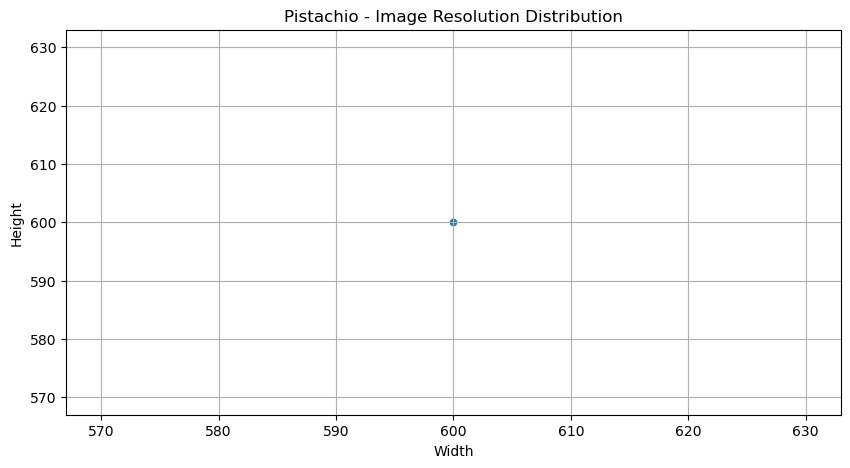


Minimum Resolution: (600, 600) (600x600)
Maximum Resolution: (600, 600) (600x600)


In [10]:
def plot_and_count_image_sizes(directory, dataset_name):
    sizes = []
    
    for img_name in os.listdir(directory):
        img_path = os.path.join(directory, img_name)
        
        if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            try:
                with Image.open(img_path) as img:
                    sizes.append(img.size)
            except Exception as e:
                print(f"Could not open image: {img_path} ({e})")
                continue
    
    # Count and sort unique resolutions by frequency
    size_counts = Counter(sizes)
    sorted_sizes = sorted(size_counts.items(), key=lambda x: x[1], reverse=True)  # sort by count descending

    print(f"\nUnique Image Resolutions in {dataset_name} (sorted by frequency):")
    for res, count in sorted_sizes:
        print(f"Resolution {res}: {count} images")
    
    # Scatter plot
    if sizes:
        widths, heights = zip(*sizes)
        plt.figure(figsize=(10, 5))
        sns.scatterplot(x=widths, y=heights)
        plt.xlabel("Width")
        plt.ylabel("Height")
        plt.title(f"{dataset_name} - Image Resolution Distribution")
        plt.grid(True)
        plt.show()

        # Show min and max resolution
        min_res = min(sizes, key=lambda x: x[0] * x[1])
        max_res = max(sizes, key=lambda x: x[0] * x[1])
        print(f"\nMinimum Resolution: {min_res} ({min_res[0]}x{min_res[1]})")
        print(f"Maximum Resolution: {max_res} ({max_res[0]}x{max_res[1]})")
    else:
        print("No image sizes to plot.")

plot_and_count_image_sizes(dataset_path, dataset_name="Pistachio")

## Check Unique Data Types

In [11]:
def get_image_data_types(directory):
    # Initialize a list to store data types
    image_data_types = []

    # Loop through each image in the folder
    for image_name in os.listdir(directory):
        image_path = os.path.join(directory, image_name)
        
        # Open the image and check the datatype
        try:
            img = Image.open(image_path)
            img_array = np.array(img)
            image_data_types.append(img_array.dtype)
        except Exception as e:
            print(f"Error processing {image_name}: {e}")
    
    # Return the unique data types
    return set(image_data_types)

# Example usage
image_data_types = get_image_data_types(dataset_path)
print("Image data types in the folder:", image_data_types)

Image data types in the folder: {dtype('uint8')}


## Check Unique File Types

In [12]:
def show_unique_file_types(directory):
    file_type_counter = Counter()

    for filename in os.listdir(directory):
        if '.' in filename:
            ext = os.path.splitext(filename)[1].lower()  # Get extension (e.g., .jpg, .txt)
            file_type_counter[ext] += 1

    if file_type_counter:
        for file_type, count in file_type_counter.items():
            print(f"File Type '{file_type}': {count} files")
    else:
        print("No files with extensions found.")

# Example usage
show_unique_file_types(dataset_path)

File Type '.jpg': 1074 files


## Check Unique Number of Channels

In [13]:
def show_image_channels(directory):
    channel_counter = Counter()

    for filename in os.listdir(directory):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif', '.webp')):
            img_path = os.path.join(directory, filename)
            try:
                with Image.open(img_path) as img:
                    channel_mode = img.mode  # e.g., 'RGB', 'RGBA', 'L'
                    channel_counter[channel_mode] += 1
            except Exception as e:
                print(f"Skipped unreadable image: {filename} ({e})")

    if channel_counter:
        for channels, count in channel_counter.items():
            print(f"Channels {channels}: {count} images")
    else:
        print("No valid images found.")

# Example usage
show_image_channels(dataset_path)

Channels RGB: 1074 images


## Check Brightness & Contrast

Analyzing images in './A_23' for luminance variability...

Finished processing 1074 images.
Number of mean intensity values collected: 1074
Number of standard deviation values collected: 1074


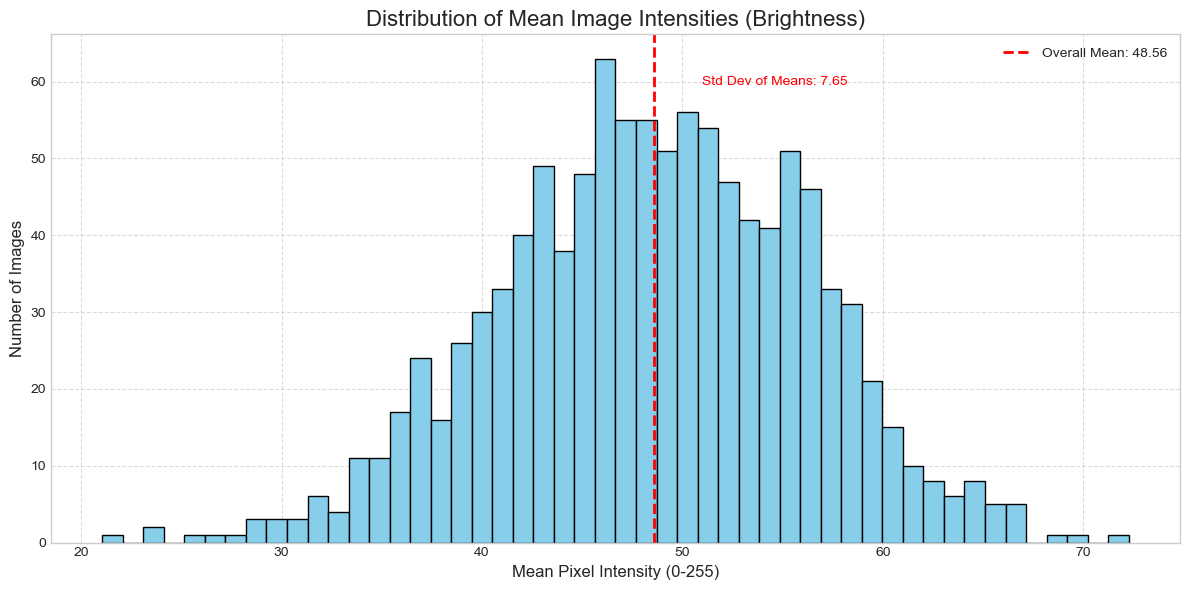

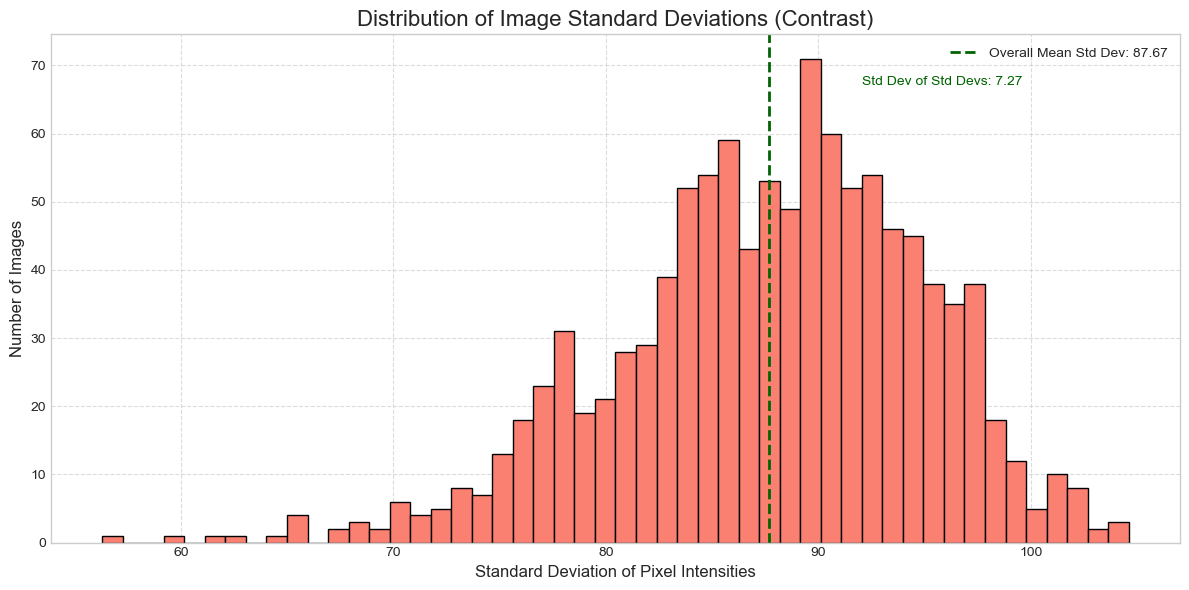


--- Summary Statistics ---
Overall Mean of Image Brightness: 48.56
Median of Image Brightness: 48.60
Std Dev of Image Brightness Distribution: 7.65
Min Image Brightness: 21.05
Max Image Brightness: 72.27

Overall Mean of Image Contrast (Std Dev): 87.67
Median of Image Contrast (Std Dev): 88.39
Std Dev of Image Contrast Distribution: 7.27
Min Image Contrast (Std Dev): 56.30
Max Image Contrast (Std Dev): 104.60


In [14]:
def analyze_luminance_variability(folder_path):
    if not os.path.isdir(folder_path):
        print(f"Error: Folder not found at {folder_path}")
        return
    # Only use jpg but for ture usage better use all
    image_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')
    mean_intensities = []
    std_devs = []
    
    print(f"Analyzing images in '{folder_path}' for luminance variability...")
    processed_images_count = 0

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(image_extensions):
            image_path = os.path.join(folder_path, filename)
            try:
                img_pil = Image.open(image_path).convert('L') # Convert to grayscale
                img_array = np.array(img_pil)
                
                mean_intensities.append(np.mean(img_array))
                std_devs.append(np.std(img_array))
                processed_images_count += 1
                
            except Exception as e:
                print(f"An error occurred while processing {filename}: {e}")

    if not mean_intensities: # Check if any images were successfully processed
        print("No valid image files found or processed in the folder.")
        return
        
    print(f"\nFinished processing {processed_images_count} images.")
    print(f"Number of mean intensity values collected: {len(mean_intensities)}")
    print(f"Number of standard deviation values collected: {len(std_devs)}")


    # Plotting the distributions
    plt.style.use('seaborn-v0_8-whitegrid') # Using a pleasant style

    # Plot distribution of mean intensities (Brightness)
    plt.figure(figsize=(12, 6))
    plt.hist(mean_intensities, bins=50, color='skyblue', edgecolor='black')
    plt.title('Distribution of Mean Image Intensities (Brightness)', fontsize=16)
    plt.xlabel('Mean Pixel Intensity (0-255)', fontsize=12)
    plt.ylabel('Number of Images', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    # Add some descriptive statistics
    mean_of_means = np.mean(mean_intensities)
    std_of_means = np.std(mean_intensities)
    plt.axvline(mean_of_means, color='red', linestyle='dashed', linewidth=2, label=f'Overall Mean: {mean_of_means:.2f}')
    plt.text(mean_of_means*1.05, plt.ylim()[1]*0.9, f'Std Dev of Means: {std_of_means:.2f}', color='red')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot distribution of standard deviations (Contrast)
    plt.figure(figsize=(12, 6))
    plt.hist(std_devs, bins=50, color='salmon', edgecolor='black')
    plt.title('Distribution of Image Standard Deviations (Contrast)', fontsize=16)
    plt.xlabel('Standard Deviation of Pixel Intensities', fontsize=12)
    plt.ylabel('Number of Images', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    # Add some descriptive statistics
    mean_of_stds = np.mean(std_devs)
    std_of_stds = np.std(std_devs)
    plt.axvline(mean_of_stds, color='darkgreen', linestyle='dashed', linewidth=2, label=f'Overall Mean Std Dev: {mean_of_stds:.2f}')
    plt.text(mean_of_stds*1.05, plt.ylim()[1]*0.9, f'Std Dev of Std Devs: {std_of_stds:.2f}', color='darkgreen')
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("\n--- Summary Statistics ---")
    if mean_intensities:
        print(f"Overall Mean of Image Brightness: {np.mean(mean_intensities):.2f}")
        print(f"Median of Image Brightness: {np.median(mean_intensities):.2f}")
        print(f"Std Dev of Image Brightness Distribution: {np.std(mean_intensities):.2f}")
        print(f"Min Image Brightness: {np.min(mean_intensities):.2f}")
        print(f"Max Image Brightness: {np.max(mean_intensities):.2f}")
    if std_devs:
        print(f"\nOverall Mean of Image Contrast (Std Dev): {np.mean(std_devs):.2f}")
        print(f"Median of Image Contrast (Std Dev): {np.median(std_devs):.2f}")
        print(f"Std Dev of Image Contrast Distribution: {np.std(std_devs):.2f}")
        print(f"Min Image Contrast (Std Dev): {np.min(std_devs):.2f}")
        print(f"Max Image Contrast (Std Dev): {np.max(std_devs):.2f}")

analyze_luminance_variability(dataset_path)

This is a great statisctoc about our dataset. WHy? Because the average image brightness is very low (48.96) on a 0-255 scale. Which confirms that our images have a domiant black background images. However, the contrast is relatively high (average of 87) meaning that the images has a predictable visual signature, a bright object of the psitachio with a dark backgroudn colour.  consistency is beneficial, as it provides a clear and stable pattern for the model to learn.

## Check Color Distribution

In [15]:
def print_channel_stats(channel_name, data):
    """Helper function to print summary statistics for a list of values."""
    if not data:
        print(f"No data for {channel_name}.")
        return
    print(f"\n-- {channel_name} --")
    print(f"Overall Mean: {np.mean(data):.2f}")
    print(f"Median: {np.median(data):.2f}")
    print(f"Std Dev: {np.std(data):.2f}")
    print(f"Min: {np.min(data):.2f}")
    print(f"Max: {np.max(data):.2f}")

def analyze_color_variability(folder_path):
    """
    Analyzes and plots color variability for images in a folder, including:
    - Distributions of average R, G, B channel intensities per image.
    - Scatter plots of average R, G, B channel intensities.
    - Distribution of average Saturation (from HSV) per image.
    """
    if not os.path.isdir(folder_path):
        print(f"Error: Folder not found at {folder_path}")
        return

    image_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.tiff') # Common static image types
    
    avg_reds = []
    avg_greens = []
    avg_blues = []
    avg_saturations = []
    
    print(f"Analyzing images in '{folder_path}' for color variability...")
    processed_images_count = 0

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(image_extensions):
            image_path = os.path.join(folder_path, filename)
            try:
                img_pil = Image.open(image_path)

                # 1. Average Channel Intensities (RGB)
                img_rgb_pil = img_pil.convert('RGB') # Ensure image is in RGB format
                img_rgb_array = np.array(img_rgb_pil)
                
                if img_rgb_array.ndim == 3 and img_rgb_array.shape[2] == 3: # Check if it's a color image
                    avg_reds.append(np.mean(img_rgb_array[:,:,0]))
                    avg_greens.append(np.mean(img_rgb_array[:,:,1]))
                    avg_blues.append(np.mean(img_rgb_array[:,:,2]))

                    # 2. Saturation Variability (HSV)
                    # Pillow's HSV conversion maps H, S, V to 0-255 range by default
                    img_hsv_pil = img_rgb_pil.convert('HSV')
                    img_hsv_array = np.array(img_hsv_pil)
                    avg_saturations.append(np.mean(img_hsv_array[:,:,1])) # Saturation is the second channel
                    
                else:
                    print(f"Warning: Skipping '{filename}' as it's not a standard RGB image (shape: {img_rgb_array.shape}).")
                    continue
            except Exception as e:
                print(f"An error occurred while processing {filename}: {e}")
        
    print(f"\nFinished processing {processed_images_count} images for color variability analysis.")

    # --- Plotting ---
    plt.style.use('seaborn-v0_8-whitegrid') # Using a pleasant style for plots

    # Part 1: Histograms of Average RGB Channel Intensities
    if avg_reds: # Check if list is not empty
        print("\nPlotting histograms of average RGB channel intensities...")
        fig_rgb_hist, axs_rgb_hist = plt.subplots(1, 3, figsize=(20, 6)) # Increased figure size
        
        axs_rgb_hist[0].hist(avg_reds, bins=50, color='red', alpha=0.75, edgecolor='black')
        axs_rgb_hist[0].set_title('Distribution of Avg. Red Intensity', fontsize=14)
        axs_rgb_hist[0].set_xlabel('Mean Red Value per Image (0-255)', fontsize=12)
        axs_rgb_hist[0].set_ylabel('Number of Images', fontsize=12)
        
        axs_rgb_hist[1].hist(avg_greens, bins=50, color='green', alpha=0.75, edgecolor='black')
        axs_rgb_hist[1].set_title('Distribution of Avg. Green Intensity', fontsize=14)
        axs_rgb_hist[1].set_xlabel('Mean Green Value per Image (0-255)', fontsize=12)
        
        axs_rgb_hist[2].hist(avg_blues, bins=50, color='blue', alpha=0.75, edgecolor='black')
        axs_rgb_hist[2].set_title('Distribution of Avg. Blue Intensity', fontsize=14)
        axs_rgb_hist[2].set_xlabel('Mean Blue Value per Image (0-255)', fontsize=12)
        
        fig_rgb_hist.suptitle('Average RGB Channel Intensities Across Images', fontsize=18, y=1.03)
        plt.tight_layout(rect=[0, 0, 1, 0.97]) # Adjust layout to prevent suptitle overlap
        plt.show()

    # Part 2: Scatter Plots of Average Channels
    if avg_reds: # Check if list is not empty
        print("\nPlotting scatter plots of average channel intensities...")
        fig_scatter, axs_scatter = plt.subplots(1, 3, figsize=(20, 6)) # Increased figure size
        
        point_size = 15 # Adjust point size for scatter plots
        point_alpha = 0.3 # Adjust alpha for transparency

        axs_scatter[0].scatter(avg_reds, avg_greens, alpha=point_alpha, s=point_size, color='purple', edgecolor='k', linewidth=0.2)
        axs_scatter[0].set_title('Avg. Red vs. Avg. Green', fontsize=14)
        axs_scatter[0].set_xlabel('Mean Red Value', fontsize=12)
        axs_scatter[0].set_ylabel('Mean Green Value', fontsize=12)
        axs_scatter[0].grid(True, linestyle=':', alpha=0.6)
        
        axs_scatter[1].scatter(avg_greens, avg_blues, alpha=point_alpha, s=point_size, color='teal', edgecolor='k', linewidth=0.2)
        axs_scatter[1].set_title('Avg. Green vs. Avg. Blue', fontsize=14)
        axs_scatter[1].set_xlabel('Mean Green Value', fontsize=12)
        axs_scatter[1].set_ylabel('Mean Blue Value', fontsize=12)
        axs_scatter[1].grid(True, linestyle=':', alpha=0.6)
        
        axs_scatter[2].scatter(avg_reds, avg_blues, alpha=point_alpha, s=point_size, color='brown', edgecolor='k', linewidth=0.2)
        axs_scatter[2].set_title('Avg. Red vs. Avg. Blue', fontsize=14)
        axs_scatter[2].set_xlabel('Mean Red Value', fontsize=12)
        axs_scatter[2].set_ylabel('Mean Blue Value', fontsize=12)
        axs_scatter[2].grid(True, linestyle=':', alpha=0.6)
        
        fig_scatter.suptitle('Relationships Between Average RGB Channel Intensities', fontsize=18, y=1.03)
        plt.tight_layout(rect=[0, 0, 1, 0.97])
        plt.show()

    # Part 3: Histogram of Average Saturation Values
    if avg_saturations: # Check if list is not empty
        print("\nPlotting histogram of average saturation values...")
        plt.figure(figsize=(10, 7)) # Increased figure size slightly
        plt.hist(avg_saturations, bins=50, color='magenta', alpha=0.75, edgecolor='black')
        plt.title('Distribution of Average Saturation per Image', fontsize=16)
        plt.xlabel('Mean Saturation Value (Pillow HSV: 0-255)', fontsize=12)
        plt.ylabel('Number of Images', fontsize=12)
        plt.grid(True, linestyle=':', alpha=0.6)
        plt.tight_layout()
        plt.show()
    
    print("\n--- Summary Statistics for Color Variability ---")
    if avg_reds: print_channel_stats("Avg Red per Image", avg_reds)
    if avg_greens: print_channel_stats("Avg Green per Image", avg_greens)
    if avg_blues: print_channel_stats("Avg Blue per Image", avg_blues)
    if avg_saturations: print_channel_stats("Avg Saturation per Image (Pillow HSV 0-255)", avg_saturations)

Analyzing images in './A_23' for color variability...

Finished processing 0 images for color variability analysis.

Plotting histograms of average RGB channel intensities...


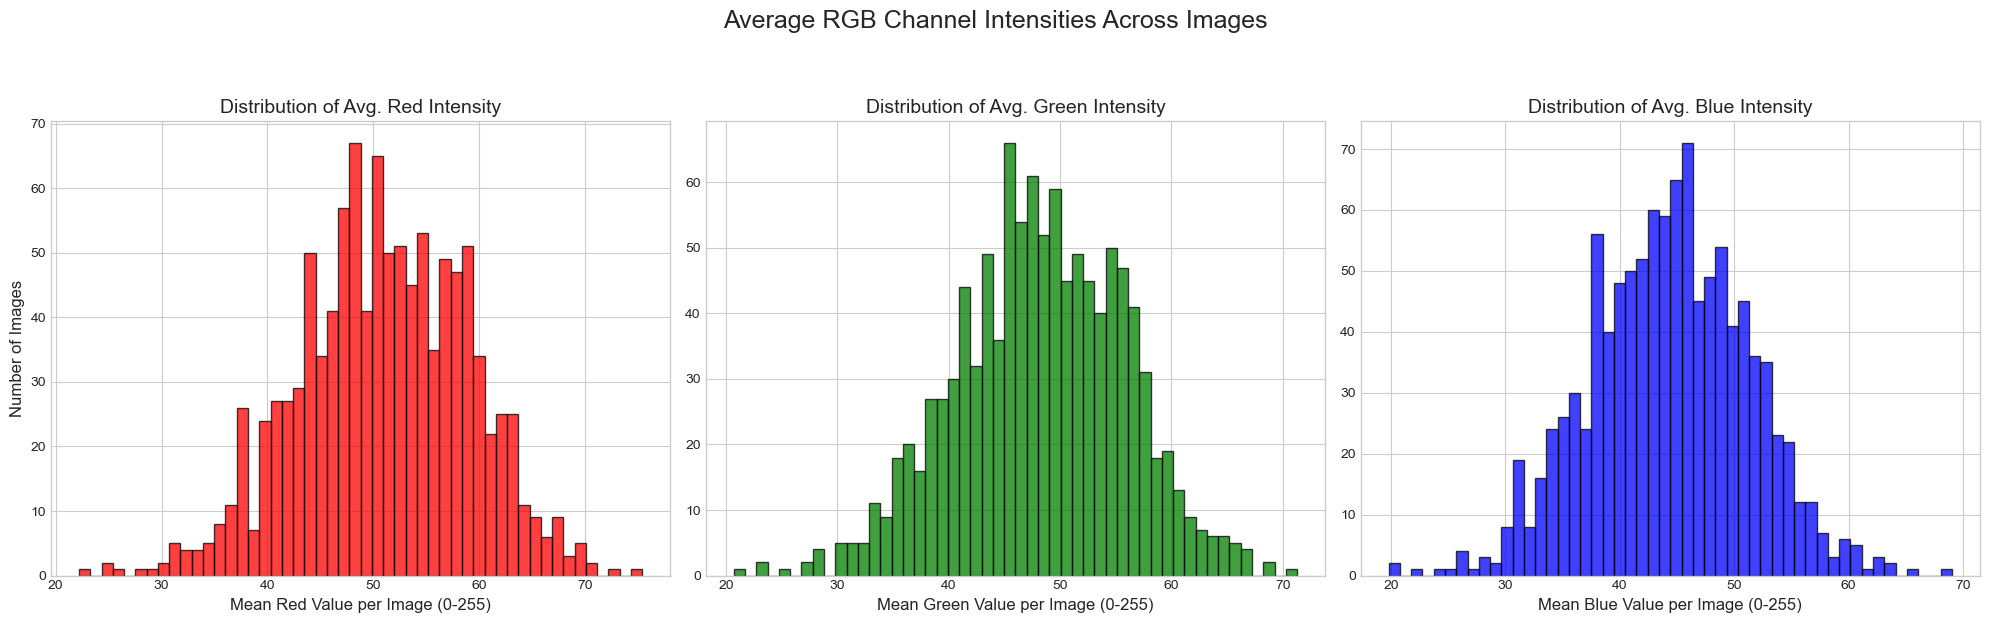


Plotting scatter plots of average channel intensities...


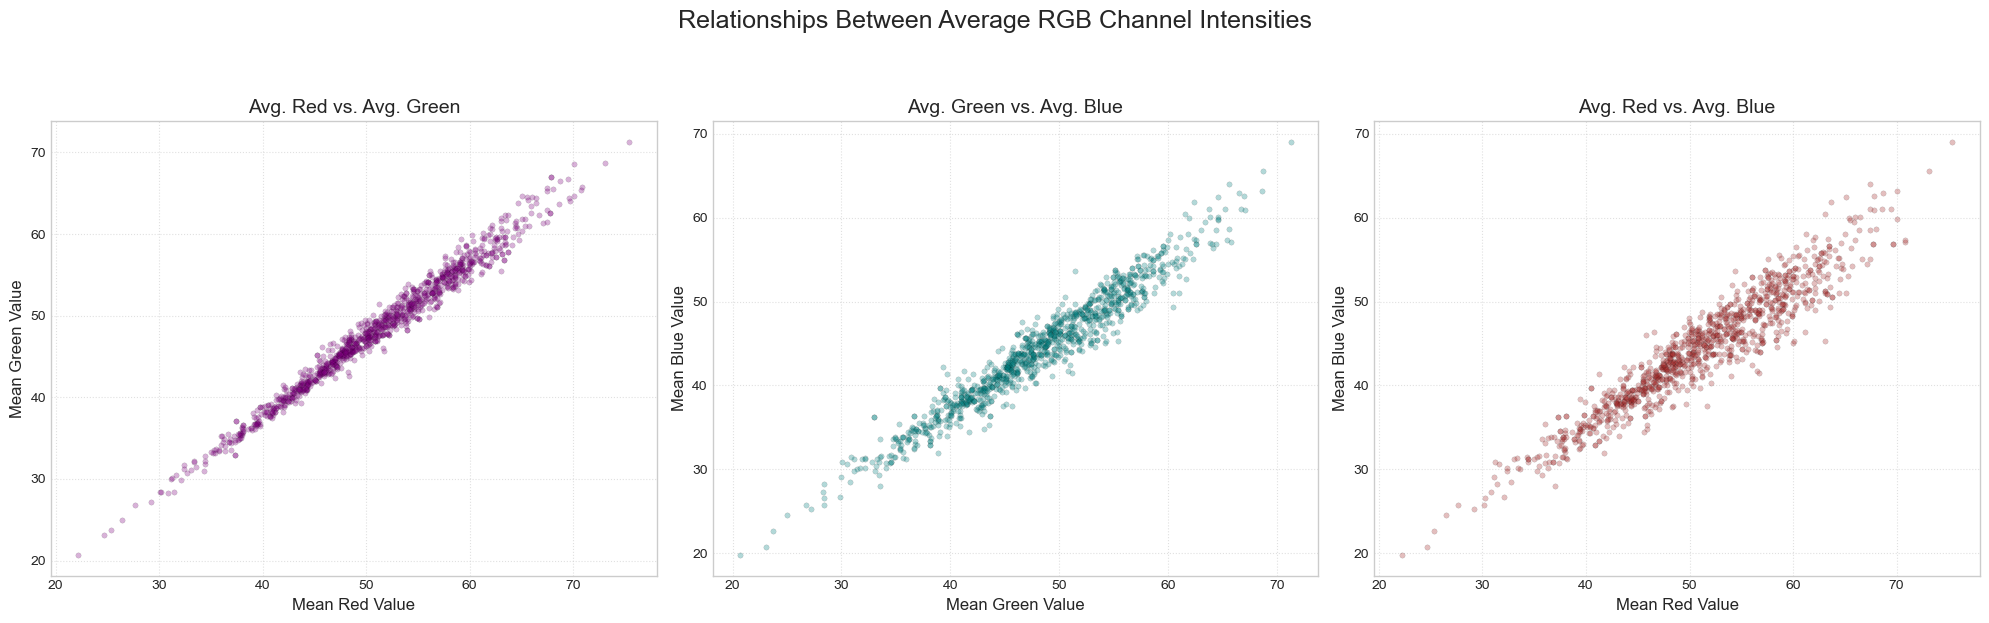


Plotting histogram of average saturation values...


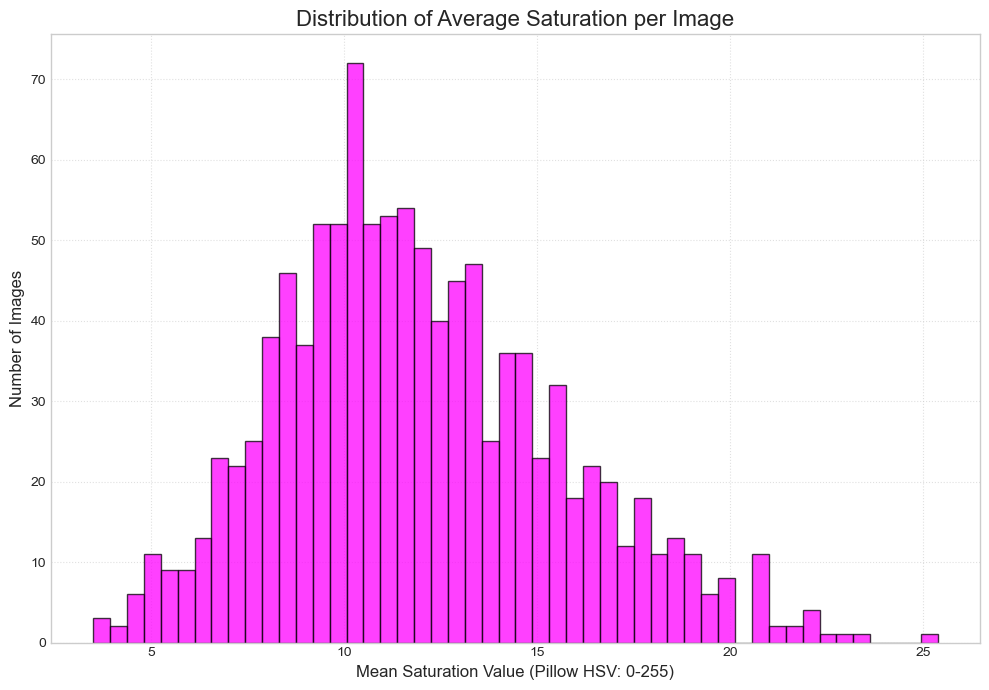


--- Summary Statistics for Color Variability ---

-- Avg Red per Image --
Overall Mean: 50.95
Median: 50.89
Std Dev: 8.04
Min: 22.21
Max: 75.40

-- Avg Green per Image --
Overall Mean: 48.17
Median: 48.26
Std Dev: 7.65
Min: 20.70
Max: 71.28

-- Avg Blue per Image --
Overall Mean: 44.30
Median: 44.47
Std Dev: 6.97
Min: 19.79
Max: 69.03

-- Avg Saturation per Image (Pillow HSV 0-255) --
Overall Mean: 11.92
Median: 11.43
Std Dev: 3.64
Min: 3.49
Max: 25.37


In [16]:
analyze_color_variability(dataset_path)

On the colour scatterplot we dont see any distict colour that is dominating or distict from the rest of the RGB colour. The average Red channel value (51.0) is slightly higher than Green (48.2) and Blue (44.3). This points to a subtle, warm, reddish-yellow tint across the dataset, which is consistent with the natural color of a pistachio. The overall color saturation is extremely low (average of 11.9 on a 0-255 scale), meaning the colors are not vibrant. This is heavily influenced by the large, colorless black background. The model will less likely to learn complex or vivid color patterns.

## Check Grainy & Blurry

Analyzing image quality (sharpness/graininess) in './A_23'...

--- Image Quality Analysis Results ---
Analyzed 1074 images.

Top 10 MOST Blurry Images (Lowest Scores):
  - Score: 89.56, File: kirmizi 352.jpg
  - Score: 91.53, File: kirmizi 355.jpg
  - Score: 93.12, File: kirmizi 348.jpg
  - Score: 102.86, File: kirmizi 501.jpg
  - Score: 103.28, File: kirmizi 511.jpg
  - Score: 104.94, File: kirmizi 226.jpg
  - Score: 106.46, File: kirmizi 509.jpg
  - Score: 109.21, File: kirmizi 256.jpg
  - Score: 110.61, File: kirmizi 9.jpg
  - Score: 111.09, File: kirmizi 508.jpg

Top 10 MOST Grainy/Noisy Images (Highest Scores):
  - Score: 340.24, File: siirt 378.jpg
  - Score: 343.16, File: siirt 306.jpg
  - Score: 347.51, File: siirt (1).jpg
  - Score: 347.51, File: siirt 2.jpg
  - Score: 349.89, File: siirt (15).jpg
  - Score: 349.89, File: siirt 234.jpg
  - Score: 360.80, File: siirt 387.jpg
  - Score: 369.92, File: siirt 229.jpg
  - Score: 389.81, File: siirt (44).jpg
  - Score: 401.47, File: 

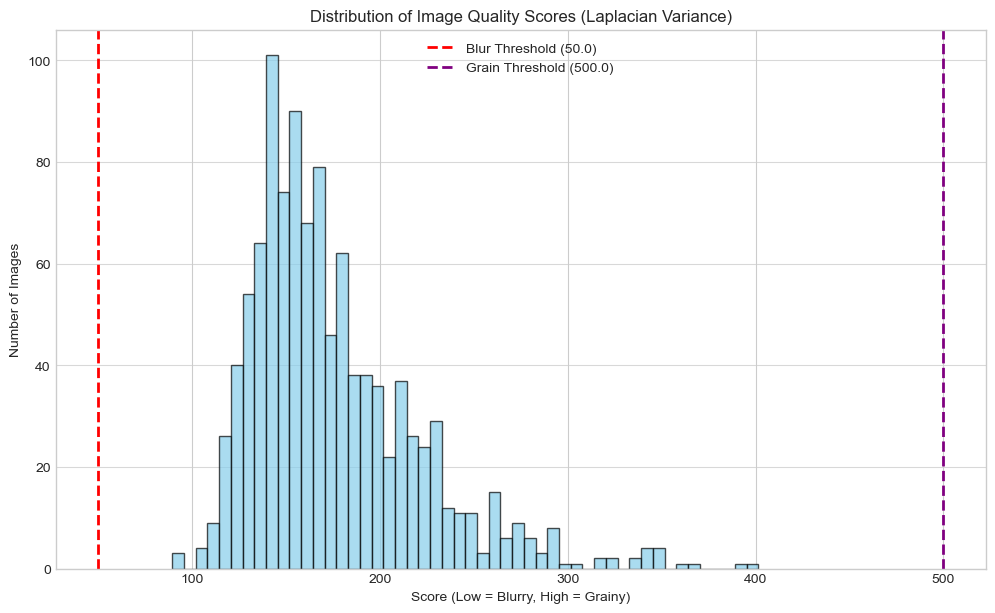


Displaying images from both extremes for visual check...


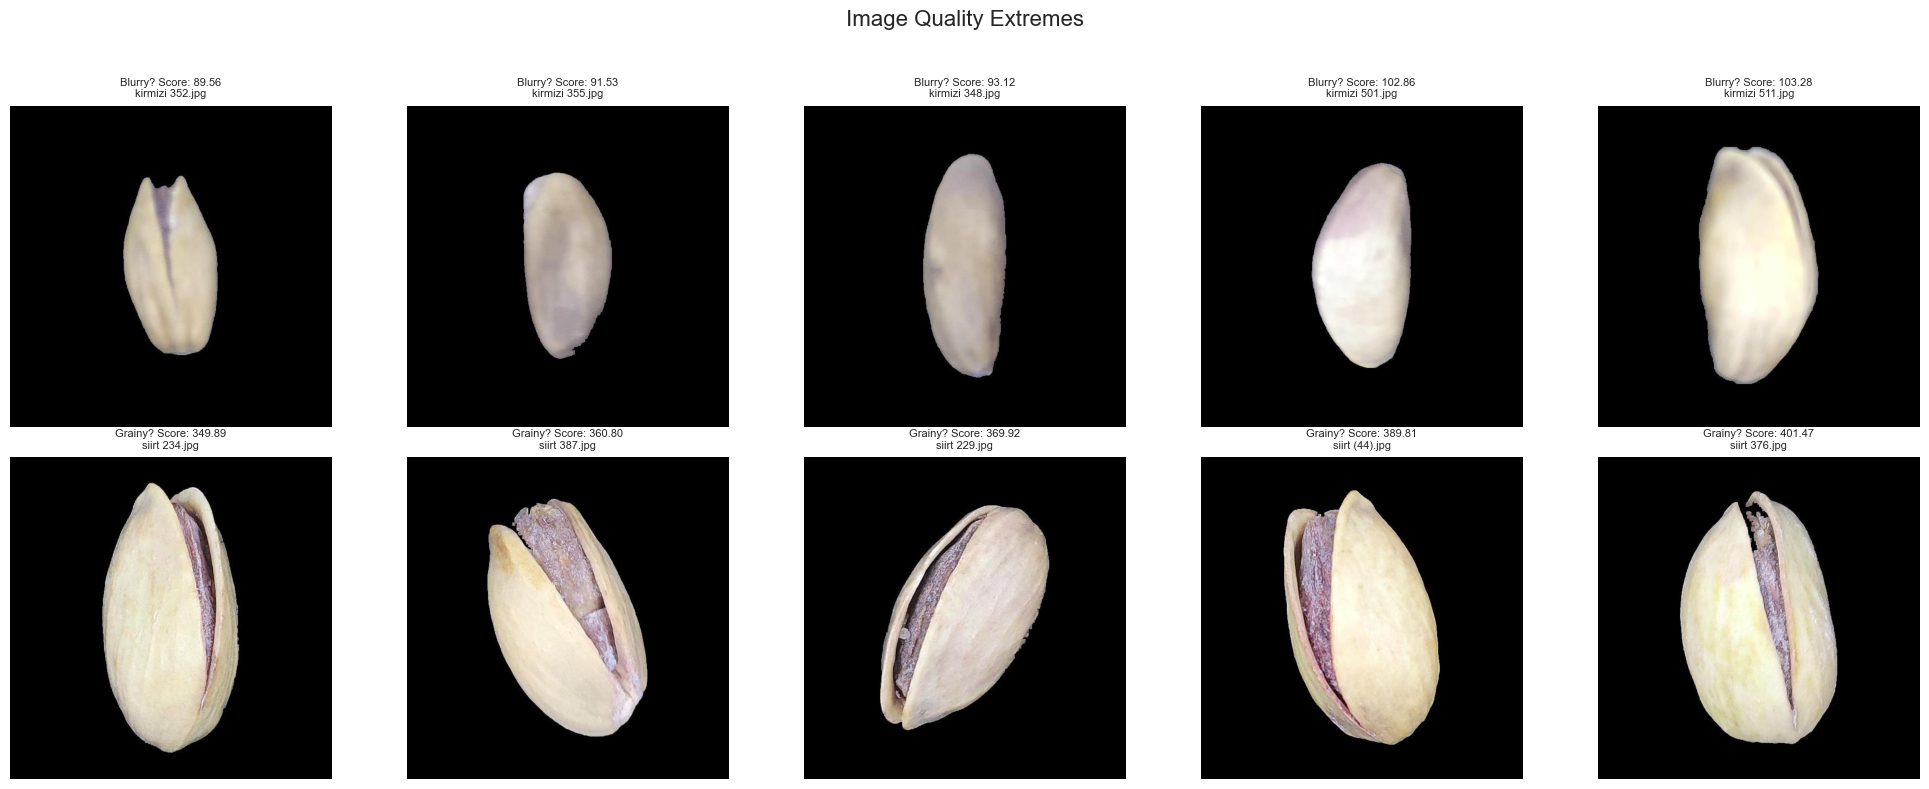

In [17]:
def diagnose_sharpness_and_graininess(folder_path, blur_threshold=50.0, grain_threshold=500.0):
    if not os.path.isdir(folder_path):
        print(f"Error: Folder not found at '{folder_path}'")
        return

    quality_scores = []
    image_extensions = ('.png', '.jpg', '.jpeg')

    print(f"Analyzing image quality (sharpness/graininess) in '{folder_path}'...")
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(image_extensions):
            image_path = os.path.join(folder_path, filename)
            img_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            
            if img_gray is None:
                continue
            
            # The same Laplacian variance is used for both blur and grain
            lap_var = cv2.Laplacian(img_gray, cv2.CV_64F).var()
            quality_scores.append((lap_var, image_path))
            
    if not quality_scores:
        print("No images found to analyze.")
        return

    # Sort images by score (lowest to highest)
    quality_scores.sort(key=lambda x: x[0])
    
    # --- Print Extremes ---
    print("\n--- Image Quality Analysis Results ---")
    print(f"Analyzed {len(quality_scores)} images.")
    
    print("\nTop 10 MOST Blurry Images (Lowest Scores):")
    for score, path in quality_scores[:10]:
        print(f"  - Score: {score:.2f}, File: {os.path.basename(path)}")
        
    print("\nTop 10 MOST Grainy/Noisy Images (Highest Scores):")
    for score, path in quality_scores[-10:]:
        print(f"  - Score: {score:.2f}, File: {os.path.basename(path)}")

    # --- Plot Histogram with both thresholds ---
    scores = [s[0] for s in quality_scores]
    plt.figure(figsize=(12, 7))
    plt.hist(scores, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    plt.title('Distribution of Image Quality Scores (Laplacian Variance)')
    plt.xlabel('Score (Low = Blurry, High = Grainy)')
    plt.ylabel('Number of Images')
    
    # Add lines for both thresholds
    plt.axvline(blur_threshold, color='red', linestyle='--', linewidth=2, label=f'Blur Threshold ({blur_threshold})')
    plt.axvline(grain_threshold, color='purple', linestyle='--', linewidth=2, label=f'Grain Threshold ({grain_threshold})')
    plt.legend()
    
    plt.grid(axis='y', alpha=0.75)
    plt.show()

    # --- Plot the most blurry and most grainy images for visual confirmation ---
    print("\nDisplaying images from both extremes for visual check...")
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    fig.suptitle('Image Quality Extremes', fontsize=16)
    
    # Plot most blurry
    for i, (score, path) in enumerate(quality_scores[:5]):
        img = Image.open(path)
        ax = axes[0, i]
        ax.imshow(img)
        ax.set_title(f"Blurry? Score: {score:.2f}\n{os.path.basename(path)}", fontsize=8)
        ax.axis('off')

    # Plot most grainy
    for i, (score, path) in enumerate(quality_scores[-5:]):
        img = Image.open(path)
        ax = axes[1, i]
        ax.imshow(img)
        ax.set_title(f"Grainy? Score: {score:.2f}\n{os.path.basename(path)}", fontsize=8)
        ax.axis('off')
        
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

diagnose_sharpness_and_graininess(dataset_path, blur_threshold=50.0, grain_threshold=500.0)

Even though the dataset is one, its actually contain from 2 types of seed: Siirt & Kirmizi. 

The Siirt images are consistently sharper, with more texture and high-frequency detail. Siirt is a specific, premium variety of pistachio, noted for being larger and more oily. The "sharpness" and "texture" we see in the data are very likely the visual representation of the nut's actual physical properties. A larger nut has more surface area for complex cracks and ridges. Its unique composition might reflect light differently. This strongly confirms that this texture is a valuable feature of the product itself and absolutely must be preserved by the model.

The Kırmızı images are consistently softer and less sharp. Kırmızı means "red," and in this context, it almost certainly refers to another distinct pistachio variety, perhaps one known for the reddish/purple color of its inner skin. This confirms that Kırmızı is not just a collection of "bad quality" photos; it's a different category of product. Its softer appearance could be due to its own unique characteristics: it might be a smaller variety, have a smoother shell, or its reddish skin might photograph differently. This reinforces our conclusion that the softness is an inherent feature of this class.

# Data Preprocessing

## Do we need to remove anything?

We are not dealing with random fluctuations. We are dealing with (at least) two distinct products with unique, consistent visual signatures. Removing the Kırmızı images would now be an even bigger mistake. It would be equivalent to telling your model to ignore an entire category of your product. A model trained only on Siirt pistachios would be useless if it ever needed to process Kırmızı pistachios.

The model's must be robust enough to accept an image of any valid pistachio variety (Siirt & Kırmızı) and perform one specific task: remove the signal degradation (the artificial Gaussian noise) while respecting the unique visual identity of the variety in the photo.

## Resize

In [18]:
PROCESSED_IMAGE_DIR = './processed_images/' 

# The uniform image size
IMG_SIZE = 100

# Create the output directory if it doesn't already exist
os.makedirs(PROCESSED_IMAGE_DIR, exist_ok=True)

# Get a list of all image files in the source directory
image_files = [f for f in os.listdir(dataset_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

print(f"Found {len(image_files)} images to resize.")

# Loop through each image file
for filename in tqdm(image_files, desc="Resizing and Saving Images"):
    try:
        # Construct full input and output paths
        input_path = os.path.join(dataset_path, filename)
        output_path = os.path.join(PROCESSED_IMAGE_DIR, filename)
        
        # Read the original image
        image = cv2.imread(input_path)
        
        # Resize the image
        resized_image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        
        # Save the resized image to the new directory
        # Using .png is a good choice as it is lossless
        cv2.imwrite(output_path, resized_image)
        
    except Exception as e:
        print(f"Could not process {filename}. Error: {e}")

print(f"All images have been resized to {IMG_SIZE}x{IMG_SIZE} and saved in '{PROCESSED_IMAGE_DIR}'.")

Found 1074 images to resize.


Resizing and Saving Images: 100%|██████████| 1074/1074 [00:01<00:00, 682.34it/s]

All images have been resized to 100x100 and saved in './processed_images/'.


## Load, Normalize, and Add Noise

In [19]:
clean_images = []
noisy_images = []

NOISE_FACTOR = 0.1

image_files = os.listdir(PROCESSED_IMAGE_DIR)

print(f"Loading {len(image_files)} pre-resized images...")

for filename in tqdm(image_files, desc="Generating Noisy Data"):
    # Construct the full path
    path = os.path.join(PROCESSED_IMAGE_DIR, filename)
    
    # Read the pre-resized image and convert to RGB
    image = cv2.imread(path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Just normalize (no resize needed!)
    image_normalized = image_rgb / 255.0
    
    # Create the noisy version
    noise = np.random.normal(loc=0.0, scale=NOISE_FACTOR, size=image_normalized.shape)
    noisy_image = image_normalized + noise
    noisy_image = np.clip(noisy_image, 0., 1.)
    
    clean_images.append(image_normalized)
    noisy_images.append(noisy_image)

# Convert lists to NumPy arrays
y_data = np.array(clean_images)
X_data = np.array(noisy_images)

print("\n--- Loading and Noise Generation Complete ---")
print(f"Shape of clean images (y_data): {y_data.shape}")
print(f"Shape of noisy images (X_data): {X_data.shape}")

Loading 1074 pre-resized images...


Generating Noisy Data: 100%|██████████| 1074/1074 [00:11<00:00, 95.66it/s]



--- Loading and Noise Generation Complete ---
Shape of clean images (y_data): (1074, 100, 100, 3)
Shape of noisy images (X_data): (1074, 100, 100, 3)


1074 resemble the count image of the data we have

100,100 is the resize images

3 is color RGB format

## Train Test Val Split

In [20]:
# Step 1: Split into 80% training and 20% temporary (for validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_data, y_data, test_size=0.2, random_state=42
)

# Step 2: Split the 20% temporary set in half to get 10% validation and 10% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print("\n--- Data Splitting Complete ---")
print(f"X_train shape: {X_train.shape} -> ({len(X_train)/len(X_data)*100:.0f}%)")
print(f"X_val shape:   {X_val.shape} -> ({len(X_val)/len(X_data)*100:.0f}%)")
print(f"X_test shape:  {X_test.shape} -> ({len(X_test)/len(X_data)*100:.0f}%)")


--- Data Splitting Complete ---
X_train shape: (859, 100, 100, 3) -> (80%)
X_val shape:   (107, 100, 100, 3) -> (10%)
X_test shape:  (108, 100, 100, 3) -> (10%)


## Optional (For future works)

In [21]:
# Create the directory if it doesn't exist
output_dir = 'Encoder_files'
os.makedirs(output_dir, exist_ok=True)

# Save arrays into the folder
np.save(os.path.join(output_dir, 'X_train.npy'), X_train)
np.save(os.path.join(output_dir, 'y_train.npy'), y_train)
np.save(os.path.join(output_dir, 'X_val.npy'), X_val)
np.save(os.path.join(output_dir, 'y_val.npy'), y_val)
np.save(os.path.join(output_dir, 'X_test.npy'), X_test)
np.save(os.path.join(output_dir, 'y_test.npy'), y_test)

print("All 6 final dataset files have been saved successfully.")

All 6 final dataset files have been saved successfully.


Actually this process so that i dont need to run from the start again and again.

# Model

In [22]:
def ssim_loss(y_true, y_pred):
    # tf.image.ssim mengembalikan nilai SSIM untuk setiap gambar dalam batch.
    return 1.0 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

def ssim_metric(y_true, y_pred):
    return tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

X_train = np.load('Encoder_files/X_train.npy')
y_train = np.load('Encoder_files/y_train.npy')
X_val = np.load('Encoder_files/X_val.npy')
y_val = np.load('Encoder_files/y_val.npy')

In [26]:
EPOCH = 1000

## Baseline

In [27]:
class BaselineAutoencoder:
    def __init__(self, input_shape=(100, 100, 3)):
        self.input_shape = input_shape
        self.model = self._build_model() 
        self._compile_model()

    def _build_model(self):
        input_img = Input(shape=self.input_shape)
        x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
        encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(encoded)
        x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
        return Model(input_img, decoded)

    def _compile_model(self):
        self.model.compile(optimizer='adam', 
                           loss=ssim_loss,         # Menggunakan loss SSIM
                           metrics=[ssim_metric]) # Memantau metrik SSIM

    def summary(self):
        self.model.summary() 

    def train(self, X_train, y_train, X_val, y_val, epochs=EPOCH, batch_size=32, patience=10):
        early_stopping = EarlyStopping(monitor='val_ssim_metric', # Memantau SSIM di data validasi
                                       mode='max',              # Tujuan: memaksimalkan SSIM
                                       patience=patience, 
                                       restore_best_weights=True,
                                       verbose=1)
        
        history = self.model.fit( 
            X_train, 
            y_train,
            epochs=epochs,
            batch_size=batch_size,
            shuffle=True,
            validation_data=(X_val, y_val),
            callbacks=[early_stopping] 
        )
        print("\n--- Finish Training ---")
        return history

    def save_model(self, file_path):
        self.model.save(file_path) 
        print(f"Model Saved at: {file_path}")

In [28]:
baseline_model = BaselineAutoencoder(input_shape=(100, 100, 3))
baseline_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 100, 100, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 25, 25, 64)        3692

We have made the model architechture the same as the requirements that are provided.

In [29]:
# Latih modelnya
history_baseline_ssim = baseline_model.train(X_train, y_train, X_val, y_val,
                                                  epochs=EPOCH,
                                                  patience=5)

Epoch 1/1000
27/27 [==============================] - 3s 77ms/step - loss: 0.6997 - ssim_metric: 0.3034 - val_loss: 0.1865 - val_ssim_metric: 0.8128
Epoch 2/1000
27/27 [==============================] - 2s 67ms/step - loss: 0.1670 - ssim_metric: 0.8331 - val_loss: 0.1560 - val_ssim_metric: 0.8424
Epoch 3/1000
27/27 [==============================] - 2s 70ms/step - loss: 0.1499 - ssim_metric: 0.8501 - val_loss: 0.1437 - val_ssim_metric: 0.8550
Epoch 4/1000
27/27 [==============================] - 2s 69ms/step - loss: 0.1430 - ssim_metric: 0.8570 - val_loss: 0.1498 - val_ssim_metric: 0.8493
Epoch 5/1000
27/27 [==============================] - 2s 69ms/step - loss: 0.1386 - ssim_metric: 0.8615 - val_loss: 0.1352 - val_ssim_metric: 0.8637
Epoch 6/1000
27/27 [==============================] - 2s 69ms/step - loss: 0.1534 - ssim_metric: 0.8467 - val_loss: 0.1607 - val_ssim_metric: 0.8385
Epoch 7/1000
27/27 [==============================] - 2s 69ms/step - loss: 0.1412 - ssim_metric: 0.8587 - 

In [30]:
baseline_model.save_model('Encoder_files/baseline_model_encoder.h5')
np.save('Encoder_files/baseline_history_encoder.npy', history_baseline_ssim.history)

Model Saved at: Encoder_files/baseline_model_encoder.h5


## Modified Model

In [31]:
class UNetDenoiseModel:
    def __init__(self, input_shape=(100, 100, 3), start_filters=64, activation='leaky_relu', dropout_rate=0.25):
        self.input_shape = input_shape
        self.start_filters = start_filters
        self.activation_name = activation
        self.dropout_rate = dropout_rate
        self.model = self._build_model()
        self._compile_model() 

    def _get_activation(self):
        if self.activation_name == 'leaky_relu':
            return LeakyReLU(alpha=0.2)
        return 'relu'

    def _build_model(self):
        input_img = Input(shape=self.input_shape)
        conv1 = Conv2D(self.start_filters, (3, 3), activation=self._get_activation(), padding='same')(input_img)
        conv1 = Conv2D(self.start_filters, (3, 3), activation=self._get_activation(), padding='same')(conv1)
        pool1 = MaxPooling2D((2, 2))(conv1)
        if self.dropout_rate > 0: pool1 = Dropout(self.dropout_rate)(pool1)
        conv2 = Conv2D(self.start_filters * 2, (3, 3), activation=self._get_activation(), padding='same')(pool1)
        conv2 = Conv2D(self.start_filters * 2, (3, 3), activation=self._get_activation(), padding='same')(conv2)
        pool2 = MaxPooling2D((2, 2))(conv2)
        if self.dropout_rate > 0: pool2 = Dropout(self.dropout_rate)(pool2)
        conv_mid = Conv2D(self.start_filters * 4, (3, 3), activation=self._get_activation(), padding='same')(pool2)
        conv_mid = Conv2D(self.start_filters * 4, (3, 3), activation=self._get_activation(), padding='same')(conv_mid)
        up2 = UpSampling2D((2, 2))(conv_mid)
        merge2 = Concatenate()([conv2, up2])
        conv_up2 = Conv2D(self.start_filters * 2, (3, 3), activation=self._get_activation(), padding='same')(merge2)
        conv_up2 = Conv2D(self.start_filters * 2, (3, 3), activation=self._get_activation(), padding='same')(conv_up2)
        up1 = UpSampling2D((2, 2))(conv_up2)
        merge1 = Concatenate()([conv1, up1])
        conv_up1 = Conv2D(self.start_filters, (3, 3), activation=self._get_activation(), padding='same')(merge1)
        conv_up1 = Conv2D(self.start_filters, (3, 3), activation=self._get_activation(), padding='same')(conv_up1)
        decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv_up1)
        return Model(input_img, decoded)

    def _compile_model(self):
        self.model.compile(optimizer='adam', 
                           loss=ssim_loss,         # Menggunakan fungsi loss SSIM kita
                           metrics=[ssim_metric]) # Memantau skor SSIM asli

    def train(self, X_train, y_train, X_val, y_val, epochs=100, batch_size=32, patience=10):

        early_stopping = EarlyStopping(monitor='val_ssim_metric', # Pantau skor SSIM di data validasi
                                       mode='max',              # Kita ingin memaksimalkan SSIM
                                       patience=patience, 
                                       restore_best_weights=True, 
                                       verbose=1)
        history = self.model.fit(
            X_train, y_train,
            epochs=epochs, batch_size=batch_size, shuffle=True,
            validation_data=(X_val, y_val),
            callbacks=[early_stopping]
        )
        return history
    def summary(self):
        self.model.summary() 

    def save_model(self, file_path):
        self.model.save(file_path)
        print(f"Model telah disimpan di: {file_path}")


In [32]:
modified_unet_model = UNetDenoiseModel(
    start_filters=64, 
    activation='leaky_relu', 
    dropout_rate=0.25
)

modified_unet_model.summary() 

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_10 (Conv2D)             (None, 100, 100, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_11 (Conv2D)             (None, 100, 100, 64  36928       ['conv2d_10[0][0]']              
                                )                                                           

The primary difference between the BaselineAutoencoder and the more advanced UNetDenoiseModel lies in their fundamental architecture and how they process information, leading to significant benefits in performance. The baseline model is a classic autoencoder that forces the input image through a progressively smaller series of layers into a highly compressed bottleneck. It then attempts to reconstruct the image using only this limited, compressed data. The main drawback of this approach is that crucial, fine-grained spatial details are often lost in the bottleneck, which can result in a blurry or inaccurate output.

The UNetDenoiseModel directly solves this problem, and that is its main benefit. It implements a U-Net architecture, which introduces skip connections. These connections create a "shortcut," feeding feature maps from the earlier, high-resolution layers of the encoder directly to the corresponding layers in the decoder. The benefit of this is immense: the decoder no longer relies solely on the compressed bottleneck data. It also receives a rich stream of high-resolution details from the input, allowing it to reconstruct the image with far greater precision, sharpness, and fidelity.

Furthermore, the U-Net model incorporates other beneficial enhancements. It is a deeper, more complex network with more filters, giving it a higher capacity to learn intricate patterns. It also adds Dropout for regularization to prevent overfitting and provides the flexibility of using a LeakyReLU activation function, which can help with training stability. In essence, the changes transform a simple model into a powerful, specialized architecture that is significantly better suited for detail-oriented tasks like image denoising.

In [33]:
modified_history = modified_unet_model.train(X_train, y_train, X_val, y_val, epochs=EPOCH, batch_size=32, patience=5)

Epoch 1/1000
27/27 [==============================] - 27s 613ms/step - loss: 0.6590 - ssim_metric: 0.3436 - val_loss: 0.2117 - val_ssim_metric: 0.7881
Epoch 2/1000
27/27 [==============================] - 9s 345ms/step - loss: 0.1791 - ssim_metric: 0.8212 - val_loss: 0.1344 - val_ssim_metric: 0.8647
Epoch 3/1000
27/27 [==============================] - 9s 326ms/step - loss: 0.1316 - ssim_metric: 0.8688 - val_loss: 0.0756 - val_ssim_metric: 0.9237
Epoch 4/1000
27/27 [==============================] - 9s 340ms/step - loss: 0.0661 - ssim_metric: 0.9339 - val_loss: 0.0599 - val_ssim_metric: 0.9396
Epoch 5/1000
27/27 [==============================] - 9s 330ms/step - loss: 0.0530 - ssim_metric: 0.9470 - val_loss: 0.0517 - val_ssim_metric: 0.9478
Epoch 6/1000
27/27 [==============================] - 9s 331ms/step - loss: 0.0482 - ssim_metric: 0.9518 - val_loss: 0.0461 - val_ssim_metric: 0.9535
Epoch 7/1000
27/27 [==============================] - 9s 339ms/step - loss: 0.0460 - ssim_metric: 0

In [34]:
modified_unet_model.save_model('Encoder_files/modified_model_encoder.h5')
np.save('Encoder_files/modified_history_encoder.npy', modified_history.history)

Model telah disimpan di: Encoder_files/modified_model_encoder.h5


## Evaluation

In [38]:
all_histories = {}
baseline_history = np.load('Encoder_files/baseline_history_encoder.npy', allow_pickle=True).item()
modified_history = np.load('Encoder_files/modified_history_encoder.npy', allow_pickle=True).item()

all_histories['A_Baseline_Autoencoder'] = baseline_history
all_histories['B_Modified_UNet'] = modified_history

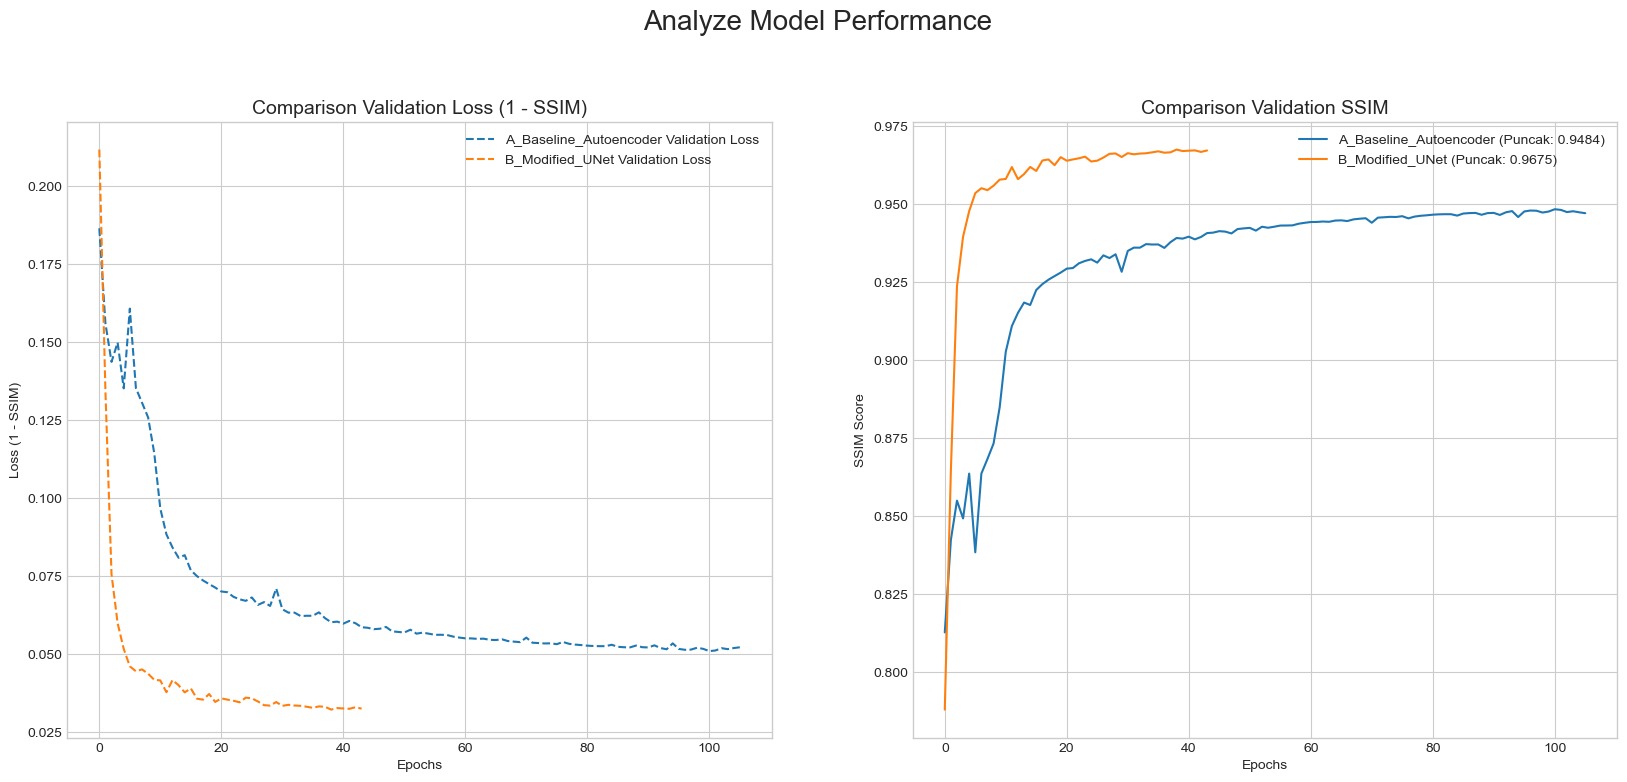

In [39]:
plt.figure(figsize=(20, 8))

# Plot 1: Comparison Loss (1 - SSIM)
plt.subplot(1, 2, 1)
for name, history in all_histories.items():
    plt.plot(history['val_loss'], label=f'{name} Validation Loss', linestyle='--')
plt.title('Comparison Validation Loss (1 - SSIM)', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Loss (1 - SSIM)')
plt.legend()
plt.grid(True)

# Plot 2: Comparison Metrik (SSIM Score)
plt.subplot(1, 2, 2)
for name, history in all_histories.items():
    max_metric = max(history['val_ssim_metric'])
    plt.plot(history['val_ssim_metric'], label=f'{name} (Puncak: {max_metric:.4f})')
plt.title('Comparison Validation SSIM', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('SSIM Score')
plt.legend()
plt.grid(True)

plt.suptitle('Analyze Model Performance', fontsize=20, y=1.02)
plt.show()

In [41]:
custom_objects = {'ssim_loss': ssim_loss, 'ssim_metric': ssim_metric}

# --- Muat Data Tes ---
X_test = np.load('Encoder_files/X_test.npy')
y_test = np.load('Encoder_files/y_test.npy')
print(f"Data tes dimuat dengan bentuk: {X_test.shape}")

# --- Muat Model yang Telah Dilatih ---
baseline_model = tf.keras.models.load_model('Encoder_files/baseline_model_encoder.h5', custom_objects=custom_objects)
modified_model = tf.keras.models.load_model('Encoder_files/modified_model_encoder.h5', custom_objects=custom_objects)

# --- Lakukan Evaluasi ---
baseline_results = baseline_model.evaluate(X_test, y_test, batch_size=32)
modified_results = modified_model.evaluate(X_test, y_test, batch_size=32)

# --- Tampilkan Hasil Perbandingan ---
print("======================================================")
print(f"  Model                 |  Loss (1 - SSIM)  |  Score SSIM  ")
print("------------------------------------------------------")
print(f"  Baseline Autoencoder  |      {baseline_results[0]:.4f}      |    {baseline_results[1]:.4f}   ")
print(f"  Modified U-Net        |      {modified_results[0]:.4f}      |    {modified_results[1]:.4f}   ")
print("======================================================")

Data tes dimuat dengan bentuk: (108, 100, 100, 3)
4/4 [==============================] - 2s 277ms/step - loss: 0.0321 - ssim_metric: 0.9679
  Model                 |  Loss (1 - SSIM)  |  Score SSIM  
------------------------------------------------------
  Baseline Autoencoder  |      0.0509      |    0.9491   
  Modified U-Net        |      0.0321      |    0.9679   


1/1 [==============================] - 0s 23ms/step


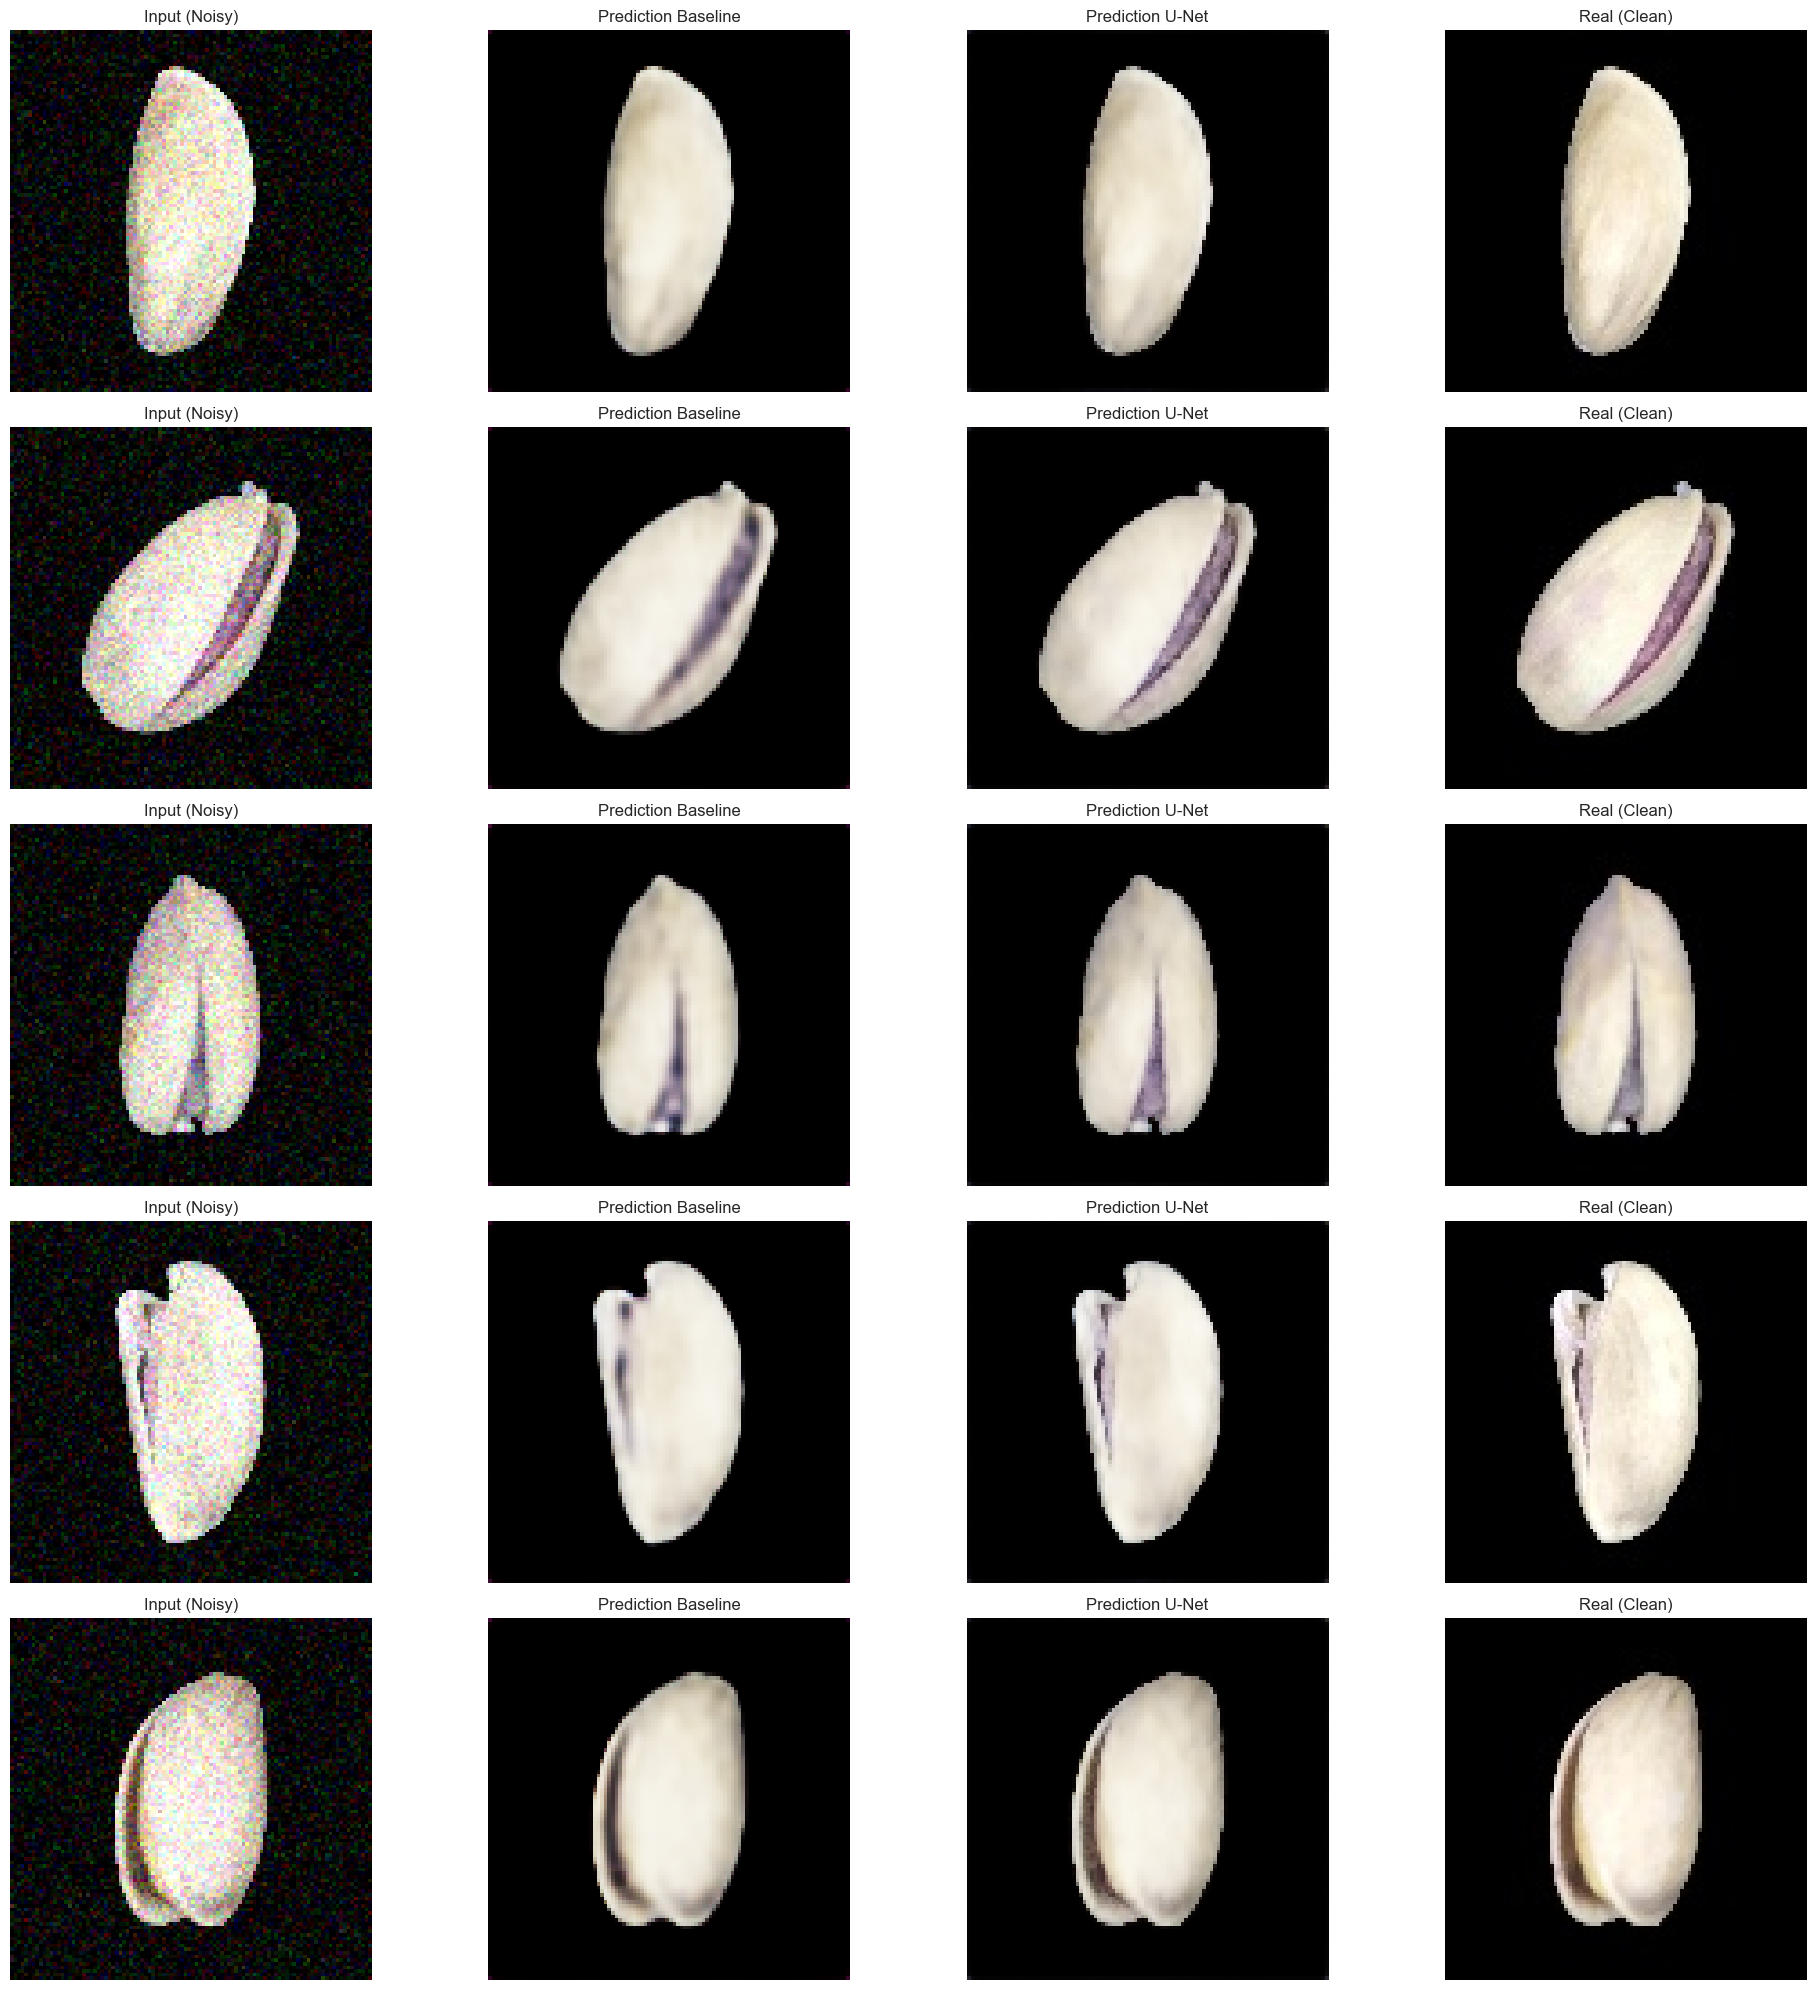

In [42]:
def plot_predictions(models, model_names, X_test, y_test, n_images=5):
    plt.figure(figsize=(20, 4 * n_images))
    
    # Ambil beberapa indeks acak dari data tes
    test_indices = np.random.choice(len(X_test), n_images, replace=False)
    
    for i, idx in enumerate(test_indices):
        # Ambil satu gambar dari setiap set
        noisy_input = X_test[idx]
        ground_truth = y_test[idx]
        
        # Buat prediksi dari semua model
        predictions = [model.predict(np.expand_dims(noisy_input, axis=0))[0] for model in models]
        
        # --- Plotting ---
        # 1. Input Ber-noise
        ax = plt.subplot(n_images, len(models) + 2, i * (len(models) + 2) + 1)
        ax.imshow(noisy_input)
        ax.set_title("Input (Noisy)")
        ax.axis('off')
        
        # 2. Prediksi dari setiap model
        for j, (name, pred) in enumerate(zip(model_names, predictions)):
            ax = plt.subplot(n_images, len(models) + 2, i * (len(models) + 2) + 2 + j)
            ax.imshow(pred)
            ax.set_title(f"Prediction {name}")
            ax.axis('off')
            
        # 3. Gambar Asli (Ground Truth)
        ax = plt.subplot(n_images, len(models) + 2, i * (len(models) + 2) + len(models) + 2)
        ax.imshow(ground_truth)
        ax.set_title("Real (Clean)")
        ax.axis('off')
        
    plt.tight_layout()
    plt.show()

plot_predictions(
    models=[baseline_model, modified_model],
    model_names=["Baseline", "U-Net"],
    X_test=X_test,
    y_test=y_test,
    n_images=5 # Tampilkan 5 contoh perbandingan
)

## Finetuning

In [44]:
output_dir = 'Encoder_files'

X_train = np.load(os.path.join(output_dir, 'X_train.npy'))
y_train = np.load(os.path.join(output_dir, 'y_train.npy'))
X_val = np.load(os.path.join(output_dir, 'X_val.npy'))
y_val = np.load(os.path.join(output_dir, 'y_val.npy'))

print("--- Data Asli Berhasil Dimuat ---")
print(f"Shape X_train: {X_train.shape}")
print(f"Shape y_train: {y_train.shape}")
print(f"Shape X_val:   {X_val.shape}")
print(f"Shape y_val:   {y_val.shape}")

--- Data Asli Berhasil Dimuat ---
Shape X_train: (859, 100, 100, 3)
Shape y_train: (859, 100, 100, 3)
Shape X_val:   (107, 100, 100, 3)
Shape y_val:   (107, 100, 100, 3)


In [ ]:
class UNetDenoiseModel:
    def __init__(self, input_shape=(100, 100, 3), start_filters=64, activation='leaky_relu', dropout_rate=0.25, learning_rate=0.001):
        self.input_shape = input_shape
        self.start_filters = start_filters
        self.activation_name = activation
        self.dropout_rate = dropout_rate
        self.learning_rate = learning_rate
        self.model = self._build_model()
        self._compile_model()

    def _get_activation(self):
        if self.activation_name == 'leaky_relu':
            return LeakyReLU(alpha=0.2)
        return 'relu'

    def _build_model(self):
        input_img = Input(shape=self.input_shape)
        conv1 = Conv2D(self.start_filters, (3, 3), activation=self._get_activation(), padding='same')(input_img)
        conv1 = Conv2D(self.start_filters, (3, 3), activation=self._get_activation(), padding='same')(conv1)
        pool1 = MaxPooling2D((2, 2))(conv1)
        if self.dropout_rate > 0: pool1 = Dropout(self.dropout_rate)(pool1)
        conv2 = Conv2D(self.start_filters * 2, (3, 3), activation=self._get_activation(), padding='same')(pool1)
        conv2 = Conv2D(self.start_filters * 2, (3, 3), activation=self._get_activation(), padding='same')(conv2)
        pool2 = MaxPooling2D((2, 2))(conv2)
        if self.dropout_rate > 0: pool2 = Dropout(self.dropout_rate)(pool2)
        conv_mid = Conv2D(self.start_filters * 4, (3, 3), activation=self._get_activation(), padding='same')(pool2)
        conv_mid = Conv2D(self.start_filters * 4, (3, 3), activation=self._get_activation(), padding='same')(conv_mid)
        up2 = UpSampling2D((2, 2))(conv_mid)
        merge2 = Concatenate()([conv2, up2])
        conv_up2 = Conv2D(self.start_filters * 2, (3, 3), activation=self._get_activation(), padding='same')(merge2)
        conv_up2 = Conv2D(self.start_filters * 2, (3, 3), activation=self._get_activation(), padding='same')(conv_up2)
        up1 = UpSampling2D((2, 2))(conv_up2)
        merge1 = Concatenate()([conv1, up1])
        conv_up1 = Conv2D(self.start_filters, (3, 3), activation=self._get_activation(), padding='same')(merge1)
        conv_up1 = Conv2D(self.start_filters, (3, 3), activation=self._get_activation(), padding='same')(conv_up1)
        decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv_up1)
        return Model(input_img, decoded)

    def _compile_model(self):
        optimizer = Adam(learning_rate=self.learning_rate)
        self.model.compile(optimizer=optimizer,
                           loss=ssim_loss,
                           metrics=[ssim_metric])

    def train(self, X_train, y_train, X_val, y_val, epochs=100, batch_size=32, patience=10):
        early_stopping = EarlyStopping(monitor='val_ssim_metric',
                                       mode='max',
                                       patience=patience,
                                       restore_best_weights=True,
                                       verbose=1)
        history = self.model.fit(
            X_train, y_train,
            epochs=epochs, batch_size=batch_size, shuffle=True,
            validation_data=(X_val, y_val),
            callbacks=[early_stopping],
            verbose=1
        )
        return history

param_grid = [
    {'start_filters': 32, 'dropout_rate': 0.2, 'activation': 'relu',       'learning_rate': 1e-3},
    {'start_filters': 64, 'dropout_rate': 0.4, 'activation': 'leaky_relu', 'learning_rate': 1e-4}
]

In [ ]:
results = []

print(f"Grid Search with {len(param_grid)} combinations...")
print("-" * 60)

for i, hyperparams in enumerate(param_grid):
    print(f"Percobaan {i+1}: {hyperparams}")
    tf.keras.backend.clear_session()
    
    hyperparams_with_shape = hyperparams.copy()
    hyperparams_with_shape['input_shape'] = X_train.shape[1:] 
    
    unet_model = UNetDenoiseModel(**hyperparams_with_shape)
    history = unet_model.train(X_train, y_train, X_val, y_val,
                                epochs=EPOCH, batch_size=32, patience=5)
    
    best_val_ssim = max(history.history['val_ssim_metric'])
    print(f"  -> Best Score Val SSIM : {best_val_ssim:.4f}\n")
    
    result_data = hyperparams.copy()
    result_data['val_ssim'] = best_val_ssim
    results.append(result_data)


Grid Search with 2 combinations...
------------------------------------------------------------
Percobaan 1: {'start_filters': 32, 'dropout_rate': 0.2, 'activation': 'relu', 'learning_rate': 0.001}
Restoring model weights from the end of the best epoch: 20.
Epoch 25: early stopping
  -> Best Score Val SSIM : 0.9638

Percobaan 2: {'start_filters': 64, 'dropout_rate': 0.4, 'activation': 'leaky_relu', 'learning_rate': 0.0001}
Restoring model weights from the end of the best epoch: 27.
Epoch 32: early stopping
  -> Best Score Val SSIM : 0.9112



## Evaluation

This first combination achieved a significantly better Best Validation SSIM score of 0.9638, demonstrating a much higher capability for accurate image reconstruction compared to the second experiment's score of 0.9112. It used a simpler model with 32 starting filters and a lower dropout rate of 0.2, suggesting that a more complex model was not necessary and that the aggressive 0.4 dropout rate in the second trial may have hindered the model's ability to learn. 

Furthermore, the higher learning rate of 0.001 allowed for faster and more effective convergence to an optimal solution, whereas the very low 0.0001 rate in the second experiment may have been too slow. In this case, even the standard relu activation proved more effective than leaky_relu. Therefore, all evidence from this test points to the parameters from Percobaan 1 being the most effective for your model.

In [ ]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='val_ssim', ascending=False)

print("\n--- Hyperparameter Tuning Result ---")
print(results_df)

best_params = results_df.iloc[0].to_dict()
best_val_score = best_params.pop('val_ssim')

print(f"\n--- Best Configuration (Skor: {best_val_score:.4f}) ---")
print(best_params)

print("\Train with best params")

best_params['start_filters'] = int(best_params['start_filters'])

tf.keras.backend.clear_session()
final_model_instance = UNetDenoiseModel(**best_params)
final_model_instance.model.summary()


--- Hyperparameter Tuning Result ---
   start_filters  dropout_rate  activation  learning_rate  val_ssim
0             32           0.2        relu         0.0010  0.963846
1             64           0.4  leaky_relu         0.0001  0.911186

--- Best Configuration (Skor: 0.9638) ---
{'start_filters': 32, 'dropout_rate': 0.2, 'activation': 'relu', 'learning_rate': 0.001}
\Train with best params
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 100, 100, 32  896         ['input_1[0][0]']          

In [53]:
final_history = final_model_instance.train(X_train, y_train, X_val, y_val,
                                           epochs=EPOCH, batch_size=32, patience=10)

Epoch 1/1000
27/27 [==============================] - 7s 181ms/step - loss: 0.7639 - ssim_metric: 0.2361 - val_loss: 0.2450 - val_ssim_metric: 0.7550
Epoch 2/1000
27/27 [==============================] - 5s 166ms/step - loss: 0.1234 - ssim_metric: 0.8766 - val_loss: 0.0773 - val_ssim_metric: 0.9227
Epoch 3/1000
27/27 [==============================] - 4s 150ms/step - loss: 0.0709 - ssim_metric: 0.9291 - val_loss: 0.0663 - val_ssim_metric: 0.9337
Epoch 4/1000
27/27 [==============================] - 4s 141ms/step - loss: 0.0597 - ssim_metric: 0.9403 - val_loss: 0.0620 - val_ssim_metric: 0.9380
Epoch 5/1000
27/27 [==============================] - 4s 140ms/step - loss: 0.0548 - ssim_metric: 0.9452 - val_loss: 0.0536 - val_ssim_metric: 0.9464
Epoch 6/1000
27/27 [==============================] - 4s 140ms/step - loss: 0.0505 - ssim_metric: 0.9495 - val_loss: 0.0501 - val_ssim_metric: 0.9499
Epoch 7/1000
27/27 [==============================] - 4s 137ms/step - loss: 0.0473 - ssim_metric: 0.

In [64]:
final_model_instance.model.save('Encoder_files/tuned_model_encoder.h5')
np.save('Encoder_files/tuned_history_encoder.npy', final_history.history)
print("Model Tuned Saved.")

Model Tuned Saved.


# FINAL Evaluation

In [55]:
output_dir = 'Encoder_files'

X_test = np.load(os.path.join(output_dir, 'X_test.npy'))
y_test = np.load(os.path.join(output_dir, 'y_test.npy'))
print(f"Shape X_test: {X_test.shape}")
print(f"Shape y_test: {y_test.shape}")

models_to_evaluate = {}
model_files = {
    "Baseline SSIM": 'Encoder_files/baseline_model_encoder.h5',
    "Modified U-Net": 'Encoder_files/modified_model_encoder.h5',
    "Tuned U-Net": 'Encoder_files/tuned_model_encoder.h5'
}

for name, file_path in model_files.items():
    if os.path.exists(file_path):
        print(f"Model '{name}' From {file_path}...")
        models_to_evaluate[name] = tf.keras.models.load_model(file_path, custom_objects=custom_objects)
    else:
        print("Eror")

Shape X_test: (108, 100, 100, 3)
Shape y_test: (108, 100, 100, 3)
Model 'Baseline SSIM' From Encoder_files/baseline_model_encoder.h5...
Model 'Modified U-Net' From Encoder_files/modified_model_encoder.h5...
Model 'Tuned U-Net' From Encoder_files/tuned_model_encoder.h5...


## Training & Val Plot

Loading history for Baseline SSIM from Encoder_files\baseline_history_encoder.npy
Loading history for Modified U-Net from Encoder_files\modified_history_encoder.npy
Loading history for Tuned U-Net from Encoder_files\tuned_history_encoder.npy


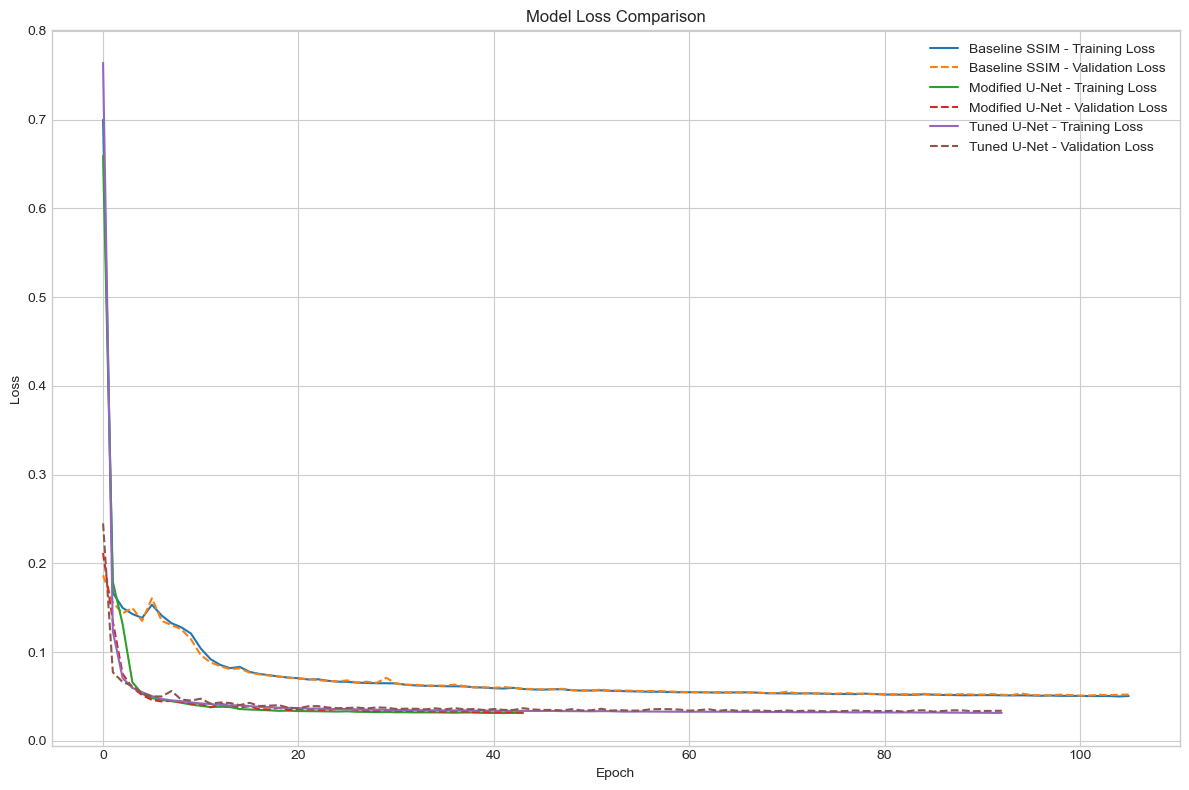

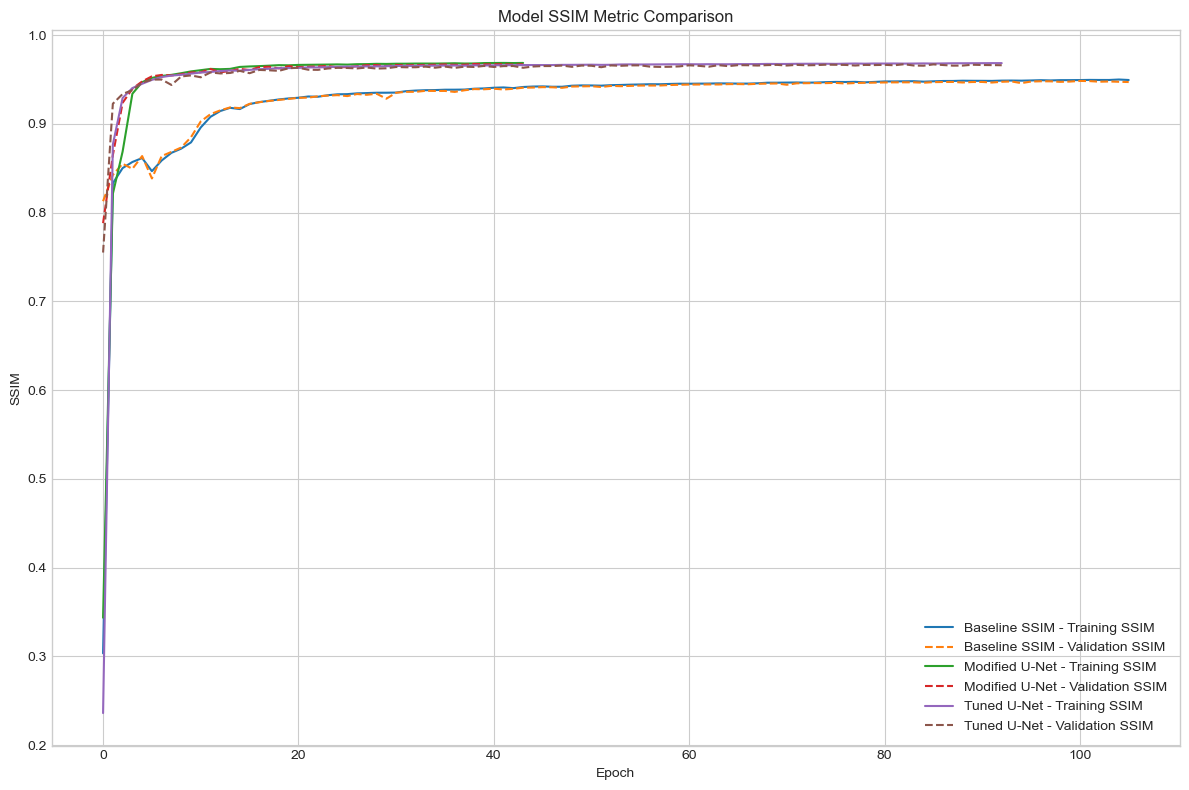

In [69]:
history_files = {
    "Baseline SSIM": os.path.join(output_dir, 'baseline_history_encoder.npy'),
    "Modified U-Net": os.path.join(output_dir, 'modified_history_encoder.npy'),
    "Tuned U-Net": os.path.join(output_dir, 'tuned_history_encoder.npy')
}

# Load all history data into dictionary
histories = {}
for name, path in history_files.items():
    if os.path.exists(path):
        print(f"Loading history for {name} from {path}")
        histories[name] = np.load(path, allow_pickle=True).item()
    else:
        print(f"[ERROR] History file not found: {path}")

plt.figure(figsize=(12, 8))
for name, history in histories.items():
    # Check if 'loss' and 'val_loss' keys exist before plotting
    if 'loss' in history:
        plt.plot(history['loss'], label=f'{name} - Training Loss')
    if 'val_loss' in history:
        plt.plot(history['val_loss'], label=f'{name} - Validation Loss', linestyle='--')

plt.title("Model Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Training and Validation SSIM Metric
plt.figure(figsize=(12, 8))
for name, history in histories.items():
    # Check if 'ssim_metric' and 'val_ssim_metric' keys exist
    if 'ssim_metric' in history:
        plt.plot(history['ssim_metric'], label=f'{name} - Training SSIM')
    if 'val_ssim_metric' in history:
        plt.plot(history['val_ssim_metric'], label=f'{name} - Validation SSIM', linestyle='--')

plt.title("Model SSIM Metric Comparison")
plt.xlabel("Epoch")
plt.ylabel("SSIM")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


The SSIM is an image quality assessment metric that evaluates the similarity between two images by considering three key factors:
- Luminance: The similarity of the average pixel intensity.
- Contrast: The similarity of the standard deviation of pixel intensities.
- Structure: The similarity of the covariance of the two images.

SSIM is designed to be more consistent with human visual perception by focusing on the structural information within an image. An SSIM score ranges from -1 to 1, where 1 indicates perfect similarity.

From this plot we can see that both the Modifed tuned or not, are outperforming the baseline model by the loss and the loss & SSIM

## Test Set 

In [ ]:
evaluation_results = []

for name, model in models_to_evaluate.items():
    print(f"Evaluate model: {name}...")
    results = model.evaluate(X_test, y_test, batch_size=32, verbose=0)
    evaluation_results.append({
        "Model": name,
        "Loss": results[0],
        "SSIM Score": results[1] 
    })

results_df = pd.DataFrame(evaluation_results)
results_df

Evaluate model: Baseline SSIM...
Evaluate model: Modified U-Net...
Evaluate model: Tuned U-Net...


,Model,Loss,SSIM Score
0,Baseline SSIM,0.050888,0.949089
1,Modified U-Net,0.032095,0.967881
2,Tuned U-Net,0.032746,0.967306


Based on the provided results, it is clear that transitioning from the Baseline model to a U-Net architecture brought about a substantial and highly beneficial improvement in performance. The Baseline model shows a loss of approximately 0.051 and an SSIM score of around 0.949. In stark contrast, both the Modified and Tuned U-Net models demonstrate vastly superior results, drastically cutting the loss down to the 0.032 range and boosting the SSIM score to approximately 0.967. This large leap confirms that the U-Net architecture is significantly more effective for this task. When comparing the two advanced versions, an interesting detail emerges: the "Modified U-Net" holds a marginal edge over the "Tuned U-Net," registering a slightly lower loss and a fractionally higher SSIM score. While this difference is minimal, suggesting their overall performance is nearly identical, it indicates that the specific configuration of the "Modified U-Net" was slightly more optimal in this final evaluation than the one achieved through the tuning process.

In [60]:
def visualize_predictions(models_dict, X_data, y_data, num_samples=5):
    print(f"\n--- Prediction for {num_samples} Sample ---")
    
    # Pilih beberapa indeks acak dari data uji
    sample_indices = np.random.choice(len(X_data), num_samples, replace=False)
    
    num_models = len(models_dict)
    num_cols = 2 + num_models  # Input + Ground Truth + all models

    for i, index in enumerate(sample_indices):
        plt.figure(figsize=(4 * num_cols, 4))
        
        noisy_input = X_data[index]
        ground_truth = y_data[index]

        # 1. Tampilkan Input Ber-noise
        plt.subplot(1, num_cols, 1)
        plt.imshow(noisy_input, cmap='gray')  # Use cmap if grayscale
        plt.title("Input Noise")
        plt.axis('off')

        # 2. Tampilkan prediksi dari setiap model
        col_idx = 2
        for model_name, model in models_dict.items():
            prediction = model.predict(np.expand_dims(noisy_input, axis=0), verbose=0)[0]

            plt.subplot(1, num_cols, col_idx)
            plt.imshow(prediction, cmap='gray')  # Use cmap if grayscale
            plt.title(f"Output: {model_name}")
            plt.axis('off')
            col_idx += 1

        # 3. Tampilkan Ground Truth
        plt.subplot(1, num_cols, num_cols)
        plt.imshow(ground_truth, cmap='gray')  # Use cmap if grayscale
        plt.title("Ground Truth")
        plt.axis('off')

        plt.suptitle(f"Comparison Sample #{i+1}", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()


## Visual


--- Prediction for 5 Sample ---


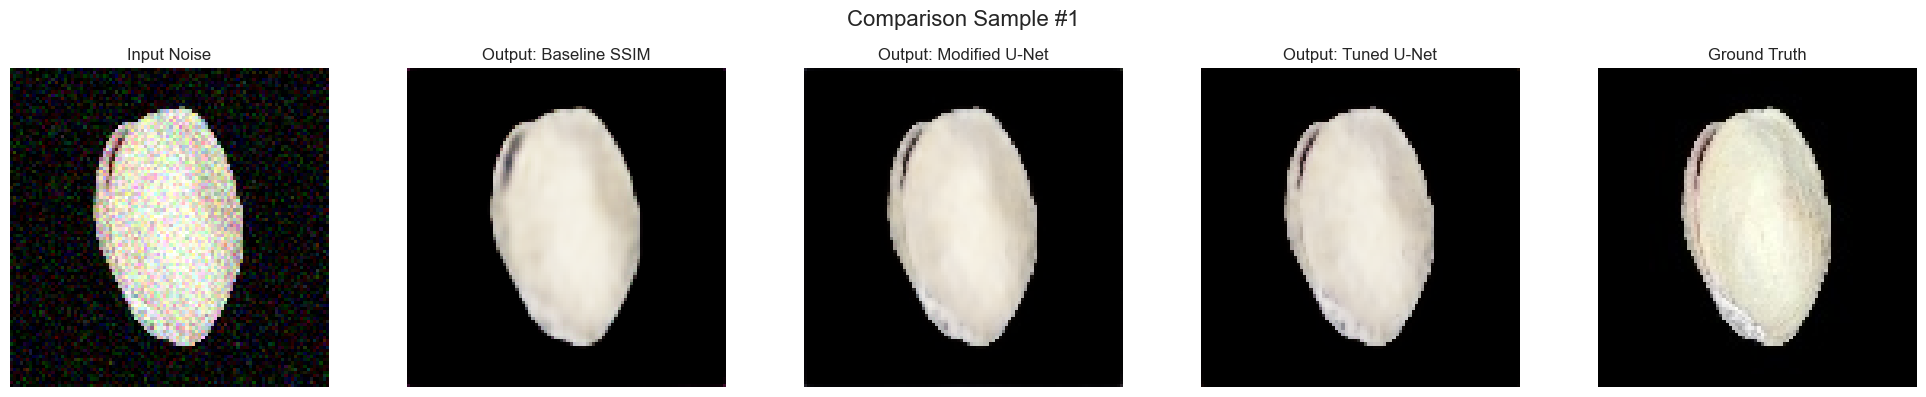

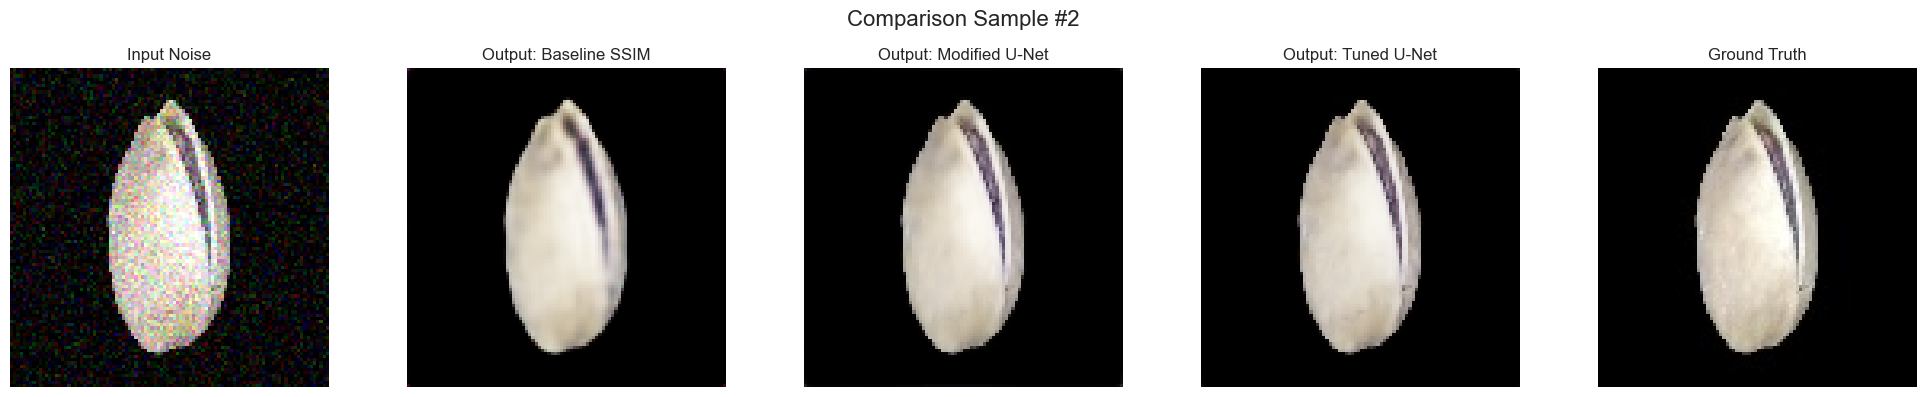

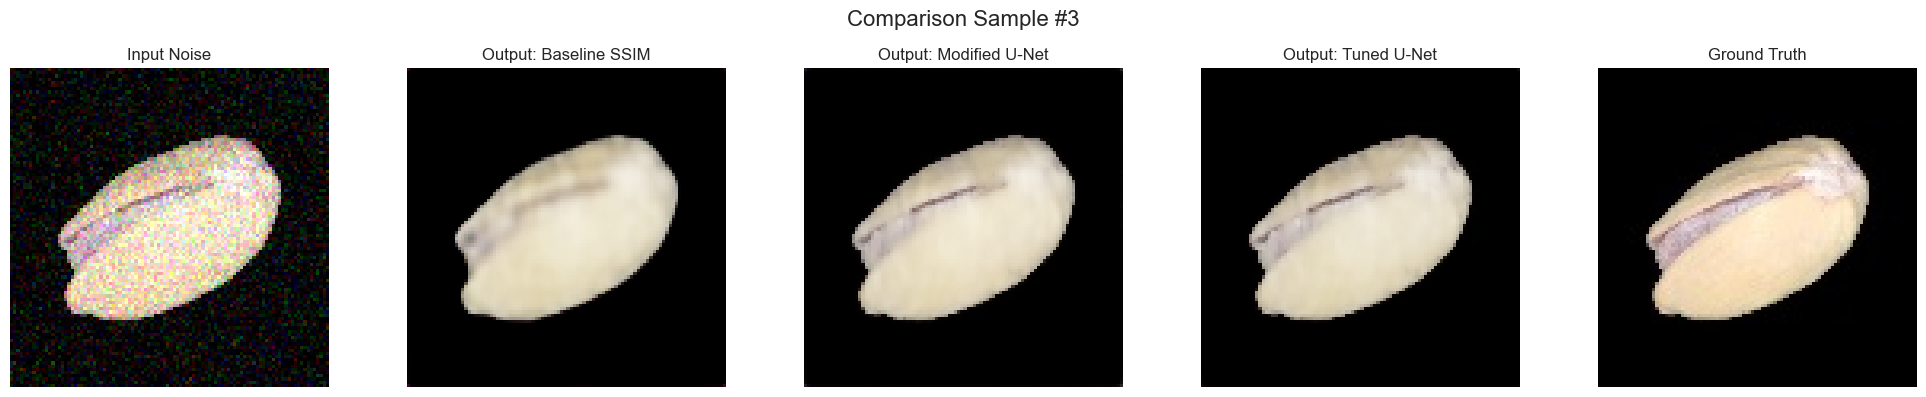

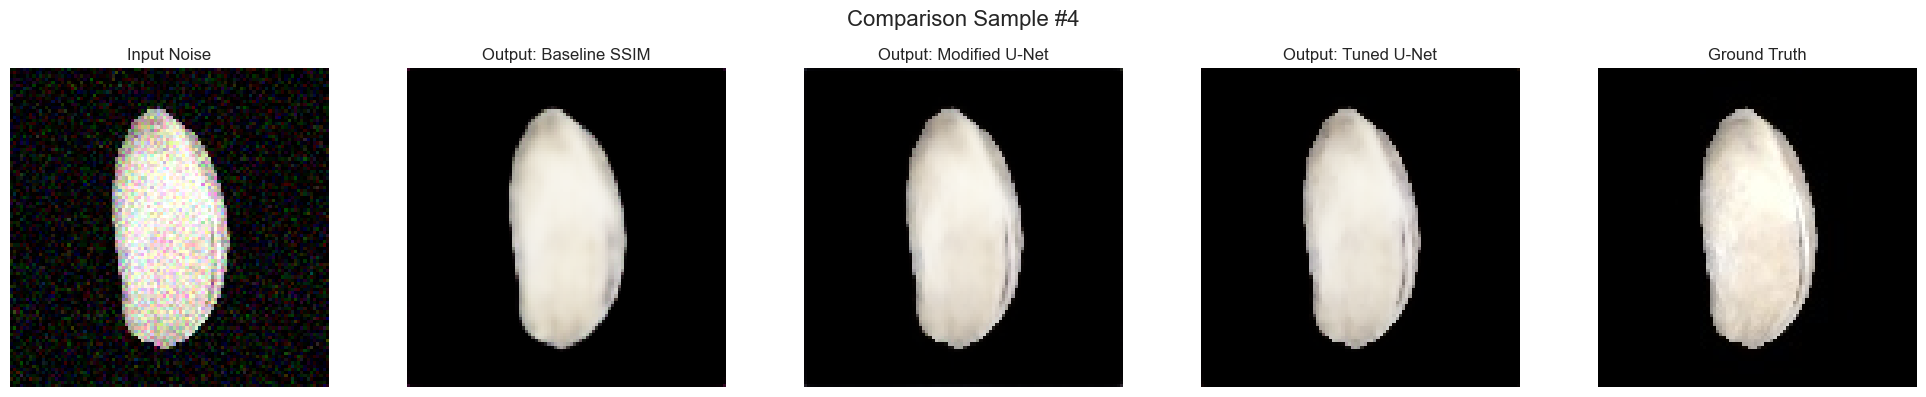

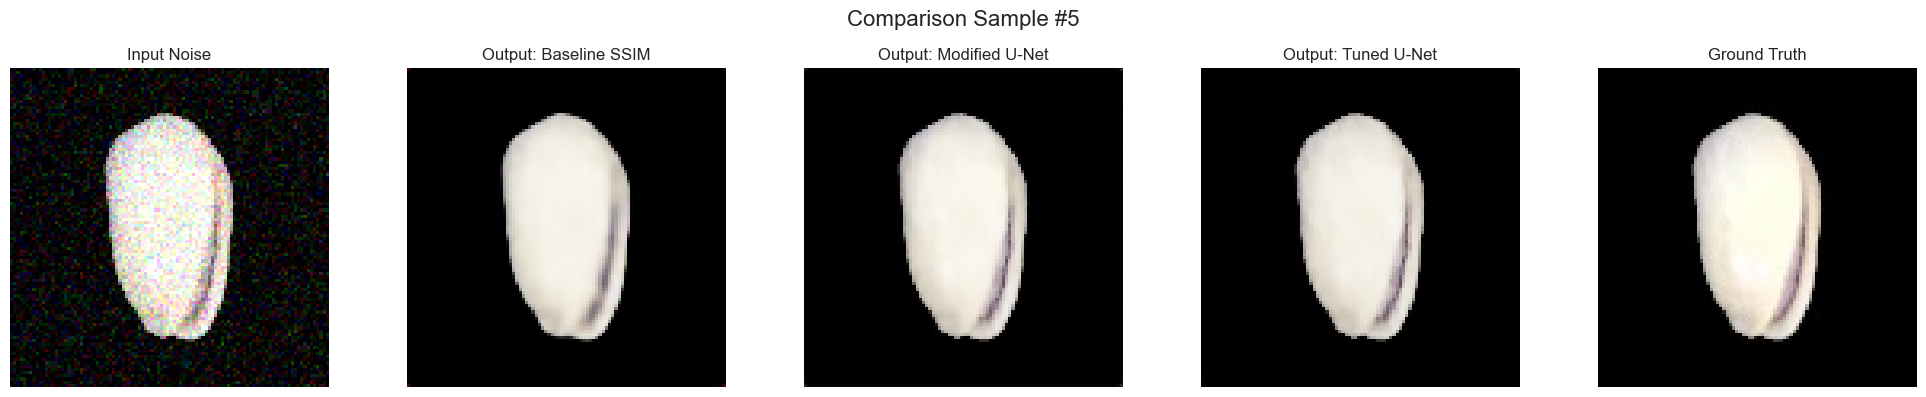

In [61]:
visualize_predictions(models_to_evaluate,X_test, y_test)

The baseline model successfully removed the most obvious noise. However, the result is noticeably blurry and lacks fine detail. The surface texture of the object is smoothed over, and important features, like the dark crevice running down the center, are soft and ill-defined. This visual quality directly explains why it received the lowest SSIM score; it gets the general shape right but loses the crucial high-frequency details.

In stark contrast, both U-Net models produced exceptionally high-quality results.
- Sharpness and Clarity: The outputs are significantly sharper and clearer than the baseline.
- Texture Restoration: They successfully reconstructed the fine, subtle textures on the object's surface that were completely lost in the baseline output.
- Feature Definition: The central dark line is crisp and well-defined, almost perfectly matching the "Ground Truth".

Visually, there is almost no perceptible difference between the output of the "Modified U-Net" and the "Tuned U-Net". Both are excellent reconstructions. This aligns perfectly with the numerical results you shared earlier, where their SSIM scores and loss values were nearly identical.